# **Classification of Sports Injuries through Biomechanical Data Analysis and Machine Learning Models**



**By:** María Emilia Aguirre

**Creation Date:** 10 / 02 / 2025

**Last Update Date:** 02 / 05 / 2025


**Universidad San Francisco de Quito**


### **1. Pipeline Description**



---


This Google Colab notebook applies an entirely
reproducible biomechanical gait-based injury classification pipeline for runners.

This notebook starts by providing details regarding dataset acquisition, importing all libraries.

The raw data were subjected to systematic preprocessing—missing-value imputation, feature selection, and derivation of a binarized injury label—prior to stratified splitting within training and test subsets.
Subsequently, five supervised classifiers (Random Forest, Multilayer Perceptron, Support Vector Machine, K-Nearest Neighbors, and Gaussian Naive Bayes) were each run under 10 k-fold cross-validation, performance rigorously quantified via accuracy, AUC, precision, recall, and F1-score. The important results are discussed through exhaustive tables and plots, followed by an in-depth discussion on limitations in methods and suggested future directions.


---




#### **1.1. Dataset Source:**

1.   Brett, A. et al. (2024) Running Injury Clinic Kinematic Dataset, figshare. Available at: https://plus.figshare.com/articles/dataset/Running_Injury_Clinic_Kinematic_Dataset/24255795/1 (Accessed: 22 April 2025).



#### **1.2. Key Papers:**



1.   Ferber, R. et al. (2024) A biomechanical dataset of 1,798 healthy and injured subjects during treadmill walking and running, Scientific data. Available at: https://pmc.ncbi.nlm.nih.gov/articles/PMC11564798/ (Accessed: 22 April 2025).





### **2. Environment and Dependencies**

In [ ]:
# Imports

import pandas as pd
import numpy as np

# Visualization & EDA
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Scikit‑learn utilities
from sklearn.model_selection    import train_test_split, StratifiedKFold
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline           import Pipeline
from sklearn.compose            import ColumnTransformer

# Example classifier (you can swap in any model)
from sklearn.ensemble           import RandomForestClassifier

import math
from sklearn.manifold            import TSNE


In [ ]:
# Python Version

!python --version

Python 3.11.12


In [ ]:
# List all installed packages and their versions
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib

print("NumPy     :", np.__version__)
print("pandas    :", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)
print("matplotlib:", matplotlib.__version__)


NumPy     : 2.0.2
pandas    : 2.2.2
scikit-learn: 1.6.1
TensorFlow: 2.18.0
matplotlib: 3.10.0


### **3. Data Description**

In [ ]:
# Format & Size

import pandas as pd

df = pd.read_csv("/content/sample_data/run_data_meta.csv")
print("Shape:", df.shape)

Shape: (1832, 26)


### **4. Exploratory Data Analysis (EDA)**

In [ ]:
# Load & Initial EDA

df = pd.read_csv('/content/sample_data/run_data_meta.csv', encoding='utf-8')
print(f"Dataset shape: {df.shape}")
display(df.head())
display(df.info())


Dataset shape: (1832, 26)


,sub_id,datestring,filename,speed_r,age,Height,Weight,Gender,DominantLeg,InjDefn,...,SpecInjury2,Activities,Level,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces
0,100433,2010-10-05 13:22,20101005T132240.json,1.610861,53,NaN,NaN,Unknown,NaN,Training volume/intensity affected,...,NaN,"walking, horseback riding, strength training",Recreational,13.0,10k,NaN,NaN,NaN,NaN,NaN
1,100434,2010-11-17 13:22,20101117T132240.json,2.237294,51,NaN,NaN,Female,NaN,Training volume/intensity affected,...,NaN,"running, swimming",Recreational,20.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
2,100537,2012-07-03 10:25,20120703T102550.json,2.127441,255,173.1,67.6,Female,Right,2 workouts missed in a row,...,NaN,"hiking, power walking, pilates",Recreational,2.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
3,100560,2012-07-17 10:37,20120717T103748.json,2.657365,33,179.3,83.0,Female,Right,No injury,...,NaN,Yoga,Recreational,NaN,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN
4,101481,2012-07-17 10:50,20120717T105021.json,2.625088,32,176.3,58.6,Female,NaN,No injury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832 entries, 0 to 1831
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sub_id        1832 non-null   int64  
 1   datestring    1832 non-null   object 
 2   filename      1832 non-null   object 
 3   speed_r       1832 non-null   float64
 4   age           1832 non-null   int64  
 5   Height        1829 non-null   float64
 6   Weight        1830 non-null   float64
 7   Gender        1832 non-null   object 
 8   DominantLeg   1480 non-null   object 
 9   InjDefn       1752 non-null   object 
 10  InjJoint      1598 non-null   object 
 11  InjSide       1346 non-null   object 
 12  SpecInjury    1243 non-null   object 
 13  InjDuration   405 non-null    float64
 14  InjJoint2     836 non-null    object 
 15  InjSide2      822 non-null    object 
 16  SpecInjury2   320 non-null    object 
 17  Activities    1516 non-null   object 
 18  Level         1563 non-null 

None

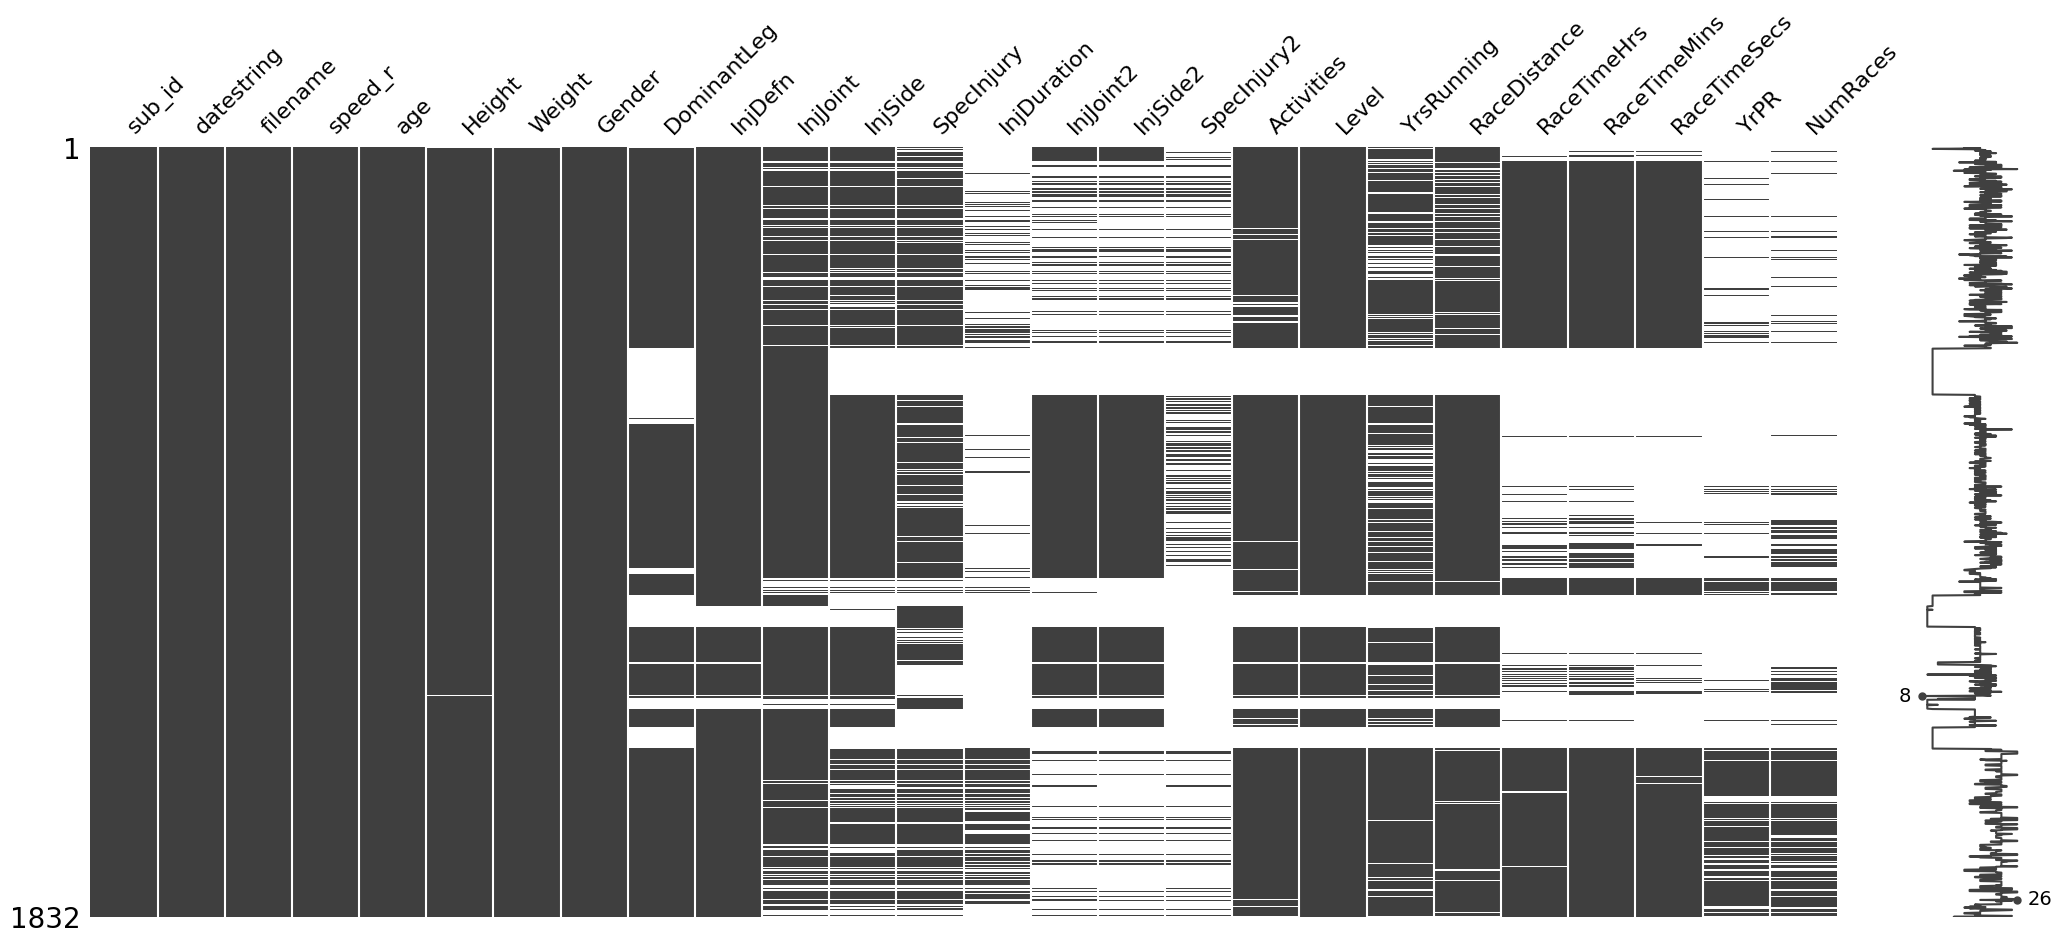

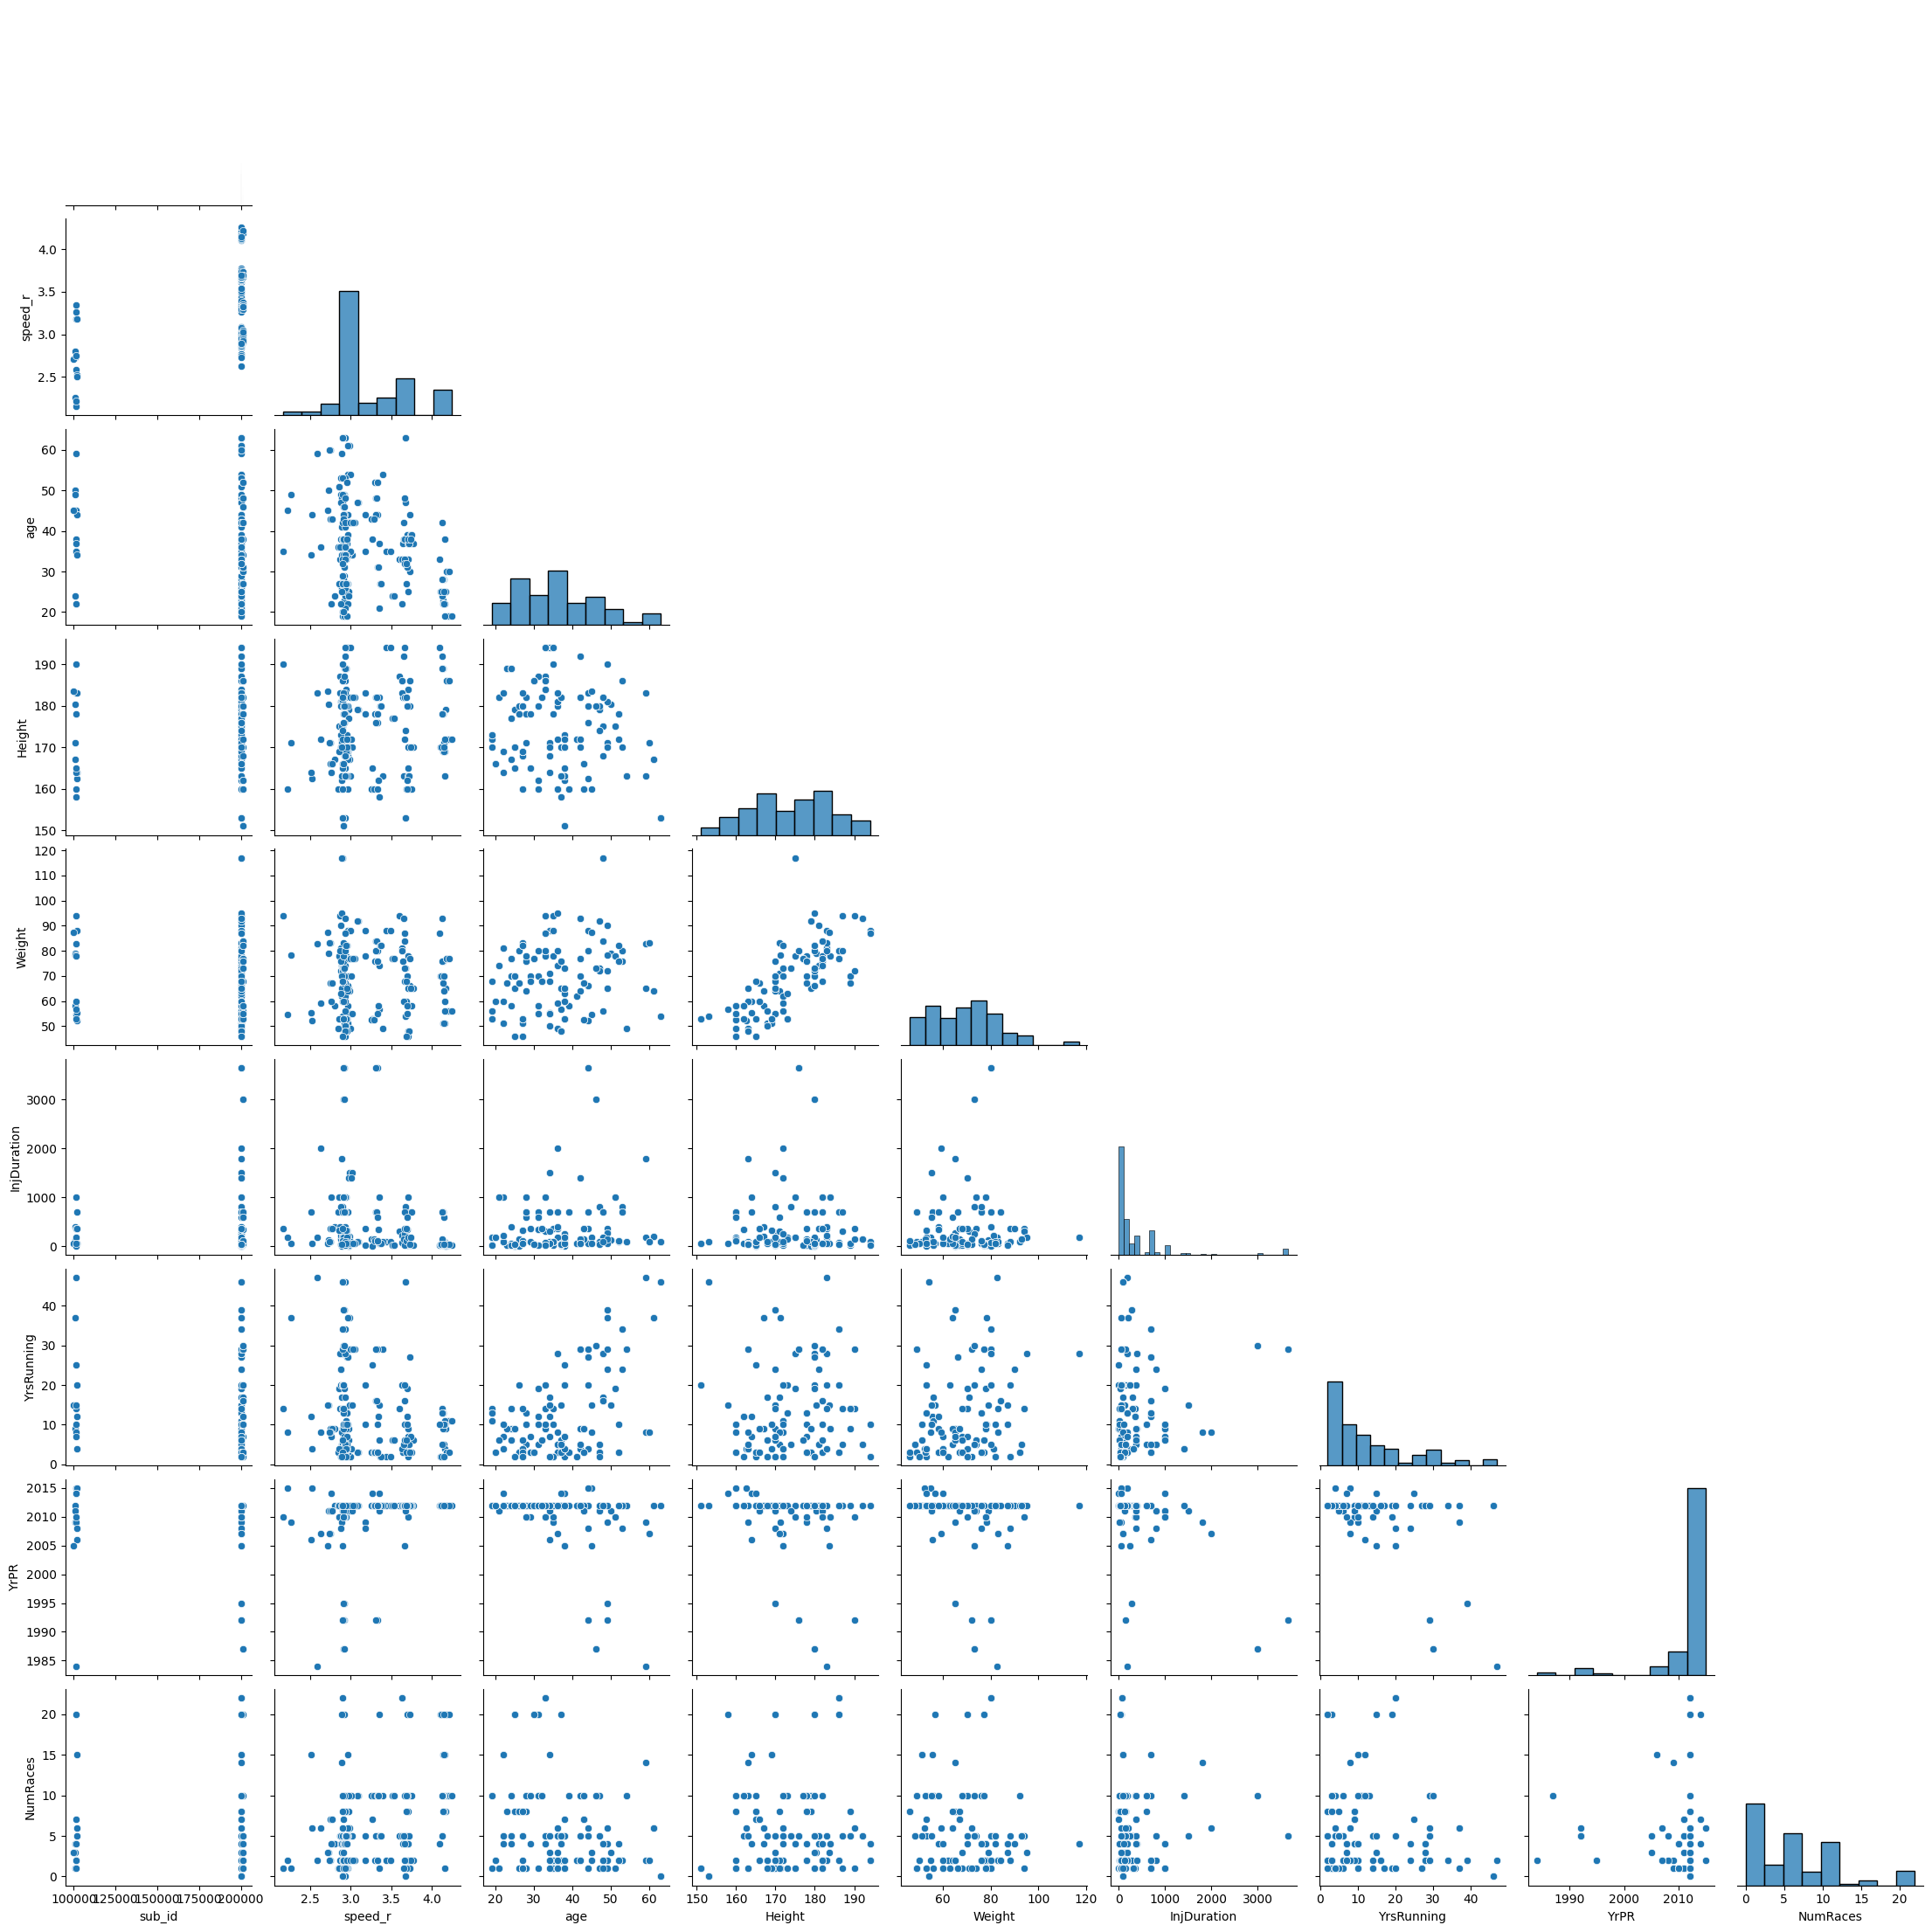

In [ ]:
# Visualize missingness & pairwise relationships
msno.matrix(df)
sns.pairplot(df.select_dtypes(include=['float64','int64']).dropna(), corner=True)

In [ ]:
# Drop non‑predictive IDs

df = df.drop(columns=["sub_id", "filename", "datestring"])

# Drop missing target & quick impute

target_col = 'InjDefn'
feature_cols = df.columns.drop(target_col)

# 3a. Drop any rows where the target is NaN
df = df.dropna(subset=[target_col]).reset_index(drop=True)

# 3b. Quick‐impute so stratify+split won’t fail
num_cols = df[feature_cols].select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df[feature_cols].select_dtypes(include=['object','category']).columns.tolist()

# median‐impute numerics
df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])
# constant‐impute categoricals
df[cat_cols] = df[cat_cols].fillna('MISSING')

In [ ]:
# 4. Split (70 / 30)

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols],
    df[target_col],
    test_size=0.3,
    stratify=df[target_col],
    random_state=42
)

# 5. Build Preprocessing + Model Pipeline

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # again, robust median impute
    ('scaler',  StandardScaler()),                    # zero‑mean/unit‑var
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer,   num_cols),
    ('cat', categorical_transformer, cat_cols),
], remainder='drop')

model_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf',      RandomForestClassifier(n_estimators=100, random_state=42))
])

# 6. Train & Evaluate
model_pipeline.fit(X_train, y_train)
test_score = model_pipeline.score(X_test, y_test)
print(f"Test accuracy: {test_score:.3f}")

Test accuracy: 0.711


In [ ]:
# Quick overview of missing data
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 speed_r         0
age             0
Height          0
Weight          0
Gender          0
DominantLeg     0
InjDefn         0
InjJoint        0
InjSide         0
SpecInjury      0
InjDuration     0
InjJoint2       0
InjSide2        0
SpecInjury2     0
Activities      0
Level           0
YrsRunning      0
RaceDistance    0
RaceTimeHrs     0
RaceTimeMins    0
RaceTimeSecs    0
YrPR            0
NumRaces        0
dtype: int64


### **5. Cleaning and Preprocessing**

In [ ]:
# Convert time columns to numeric
time_cols = ['RaceTimeHrs', 'RaceTimeMins', 'RaceTimeSecs']
df[time_cols] = df[time_cols].apply(pd.to_numeric, errors='coerce')

# Normalize 'Unknown' → NaN
df.replace('Unknown', np.nan, inplace=True)

# Identify feature types
numeric_cols     = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("\n=== Feature Types ===")
print(f"• Numeric columns   : {', '.join(numeric_cols)}")
print(f"• Categorical columns: {', '.join(categorical_cols)}")

# Drop duplicates (if any)
dupe_count = df.duplicated().sum()
if dupe_count:
    df.drop_duplicates(inplace=True)
    print(f"\nDropped {dupe_count} duplicate rows. New shape: {df.shape}")

# One‑Hot encode & MinMax‑scale
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_processed[numeric_cols] = MinMaxScaler().fit_transform(df_processed[numeric_cols])

print("\n=== Processed Dataset Preview ===")
print(df_processed.head().to_string(index=False))

# Top categories summary
print("\n=== Top 5 Values per Categorical Column ===")
for col in categorical_cols:
    vc = df[col].value_counts()
    top5 = vc.head(5)
    print(f"\n{col} ({vc.size} uniques):")
    for val, cnt in top5.items():
        print(f"  - {val}: {cnt}")


=== Feature Types ===
• Numeric columns   : speed_r, age, Height, Weight, InjDuration, YrsRunning, RaceTimeHrs, RaceTimeMins, RaceTimeSecs, YrPR, NumRaces
• Categorical columns: Gender, DominantLeg, InjDefn, InjJoint, InjSide, SpecInjury, InjJoint2, InjSide2, SpecInjury2, Activities, Level, RaceDistance

=== Processed Dataset Preview ===
 speed_r      age   Height   Weight  InjDuration  YrsRunning  RaceTimeHrs  RaceTimeMins  RaceTimeSecs     YrPR  NumRaces  Gender_Male  DominantLeg_Left  DominantLeg_MISSING  DominantLeg_Right  InjDefn_Continuing to train in pain  InjDefn_No injury  InjDefn_Training volume/intensity affected  InjJoint_Foot  InjJoint_Hip/Pelvis  InjJoint_Knee  InjJoint_Lower Leg  InjJoint_Lumbar Spine  InjJoint_MISSING  InjJoint_No Injury  InjJoint_No injury,No injury  InjJoint_Other  InjJoint_Sacroiliac Joint  InjJoint_Thigh  InjSide_Left  InjSide_MISSING  InjSide_Right  SpecInjury_Bursitis  SpecInjury_Calf muscle strain  SpecInjury_Chondromalacia  SpecInjury_Compartme

In [ ]:
# Convert time cols & normalize Unknown
time_cols = ['RaceTimeHrs','RaceTimeMins','RaceTimeSecs']
df[time_cols] = df[time_cols].apply(pd.to_numeric, errors='coerce')
df.replace('Unknown', np.nan, inplace=True)

# Identify types
numeric_cols     = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Feature summary table
feat_df = pd.DataFrame({
    'feature': numeric_cols + categorical_cols,
    'type':    ['numeric'] * len(numeric_cols) + ['categorical'] * len(categorical_cols)
})
print("\n## Feature Types")
print(feat_df.to_markdown(index=False))

# Duplicates check
dupes = df.duplicated().sum()
if dupes:
    df.drop_duplicates(inplace=True)
    print(f"\nDropped **{dupes}** duplicate rows; new shape **{df.shape}**.")

# One‑Hot + MinMax
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_processed[numeric_cols] = MinMaxScaler().fit_transform(df_processed[numeric_cols])

# Preview
print("\n## Processed Data (first 5 rows)")
print(df_processed.head().to_markdown(index=False))

# Categorical summary table
cat_summary = []
for col in categorical_cols:
    vc = df[col].value_counts().head(3)
    cat_summary.append({
        'column':      col,
        'uniques':     df[col].nunique(),
        'top_3_vals':  ', '.join(vc.index.astype(str)),
        'top_3_counts': ', '.join(vc.astype(str))
    })

cat_df = pd.DataFrame(cat_summary)
print("\n## Categorical Variables Summary")
print(cat_df.to_markdown(index=False))


## Feature Types
| feature      | type        |
|:-------------|:------------|
| speed_r      | numeric     |
| age          | numeric     |
| Height       | numeric     |
| Weight       | numeric     |
| InjDuration  | numeric     |
| YrsRunning   | numeric     |
| RaceTimeHrs  | numeric     |
| RaceTimeMins | numeric     |
| RaceTimeSecs | numeric     |
| YrPR         | numeric     |
| NumRaces     | numeric     |
| Gender       | categorical |
| DominantLeg  | categorical |
| InjDefn      | categorical |
| InjJoint     | categorical |
| InjSide      | categorical |
| SpecInjury   | categorical |
| InjJoint2    | categorical |
| InjSide2     | categorical |
| SpecInjury2  | categorical |
| Activities   | categorical |
| Level        | categorical |
| RaceDistance | categorical |

## Processed Data (first 5 rows)
|   speed_r |       age |   Height |    Weight |   InjDuration |   YrsRunning |   RaceTimeHrs |   RaceTimeMins |   RaceTimeSecs |     YrPR |   NumRaces | Gender_Male   | Dom

## **6. Visualization**

### **6.1. Histogram**

ZeroDivisionError: float division by zero

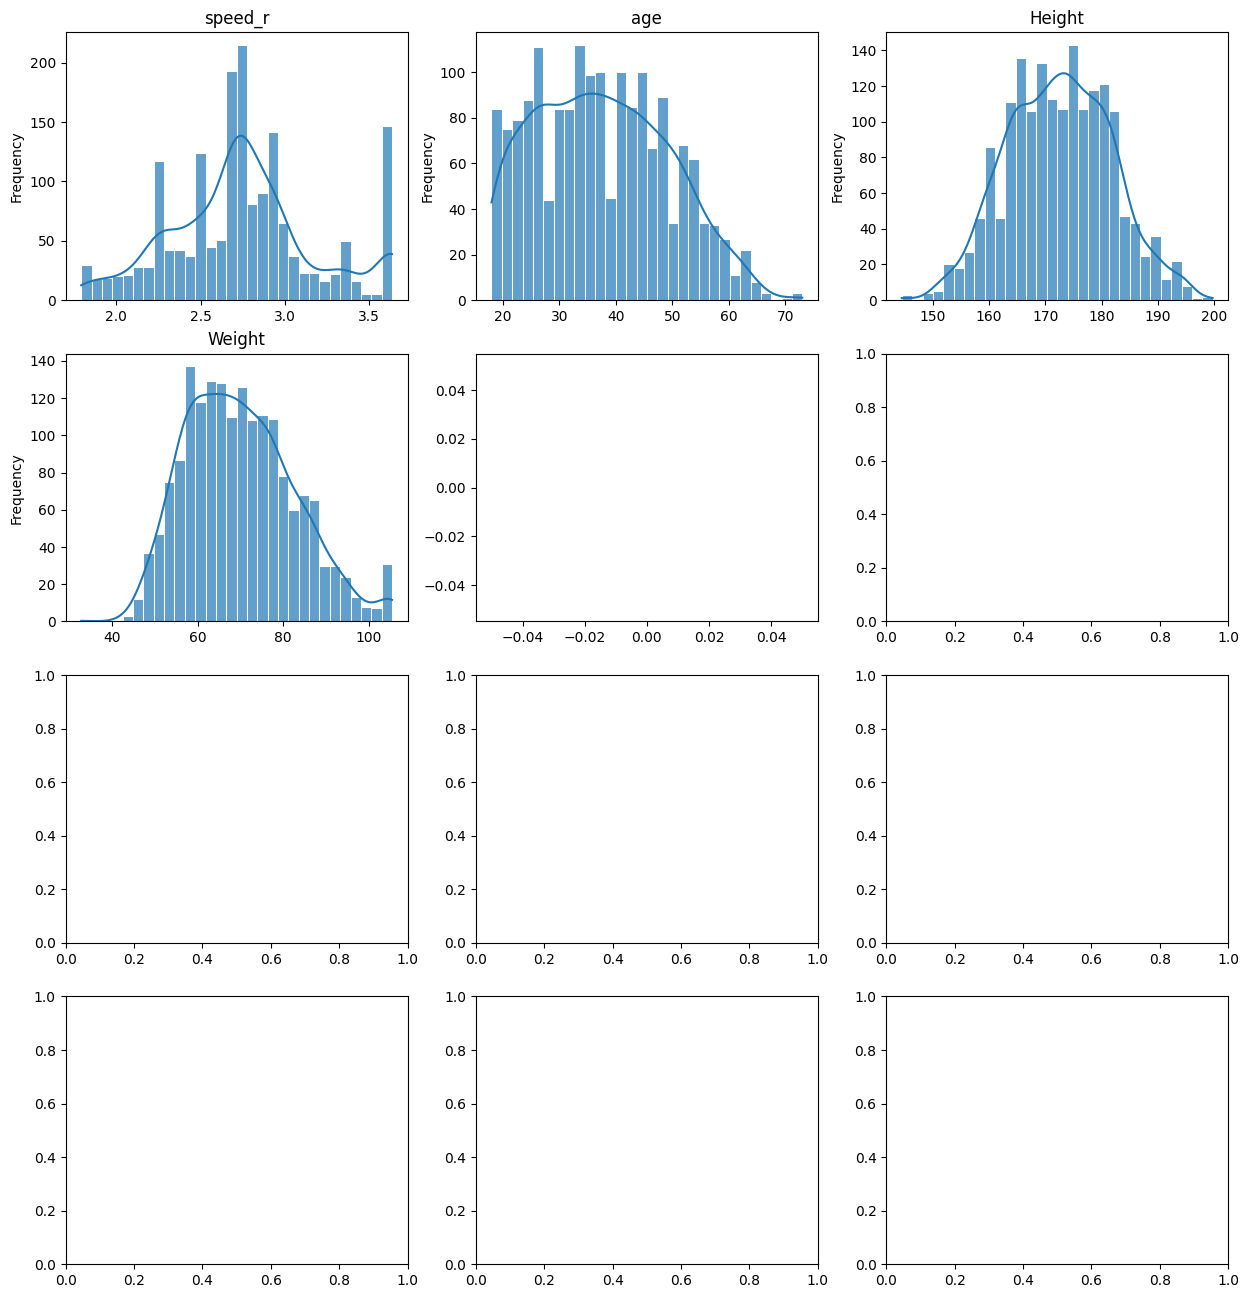

In [ ]:
# Grab all numeric columns
numeric_cols = df.select_dtypes(include='number').columns.tolist()
n = len(numeric_cols)

# Grid
ncols = 3
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
axes = axes.flatten()

# Loop and plot
for ax, col in zip(axes, numeric_cols):
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        ax=ax,
        binwidth=(df[col].max() - df[col].min()) / 30,  # ~30 bins
        edgecolor='w',
        alpha=0.7
    )
    ax.set_title(col, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

# Turn off any leftover axes
for ax in axes[n:]:
    ax.set_visible(False)

plt.suptitle("Distribution of Numeric Features", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### **6.2. Pearson Correlation Matrix**

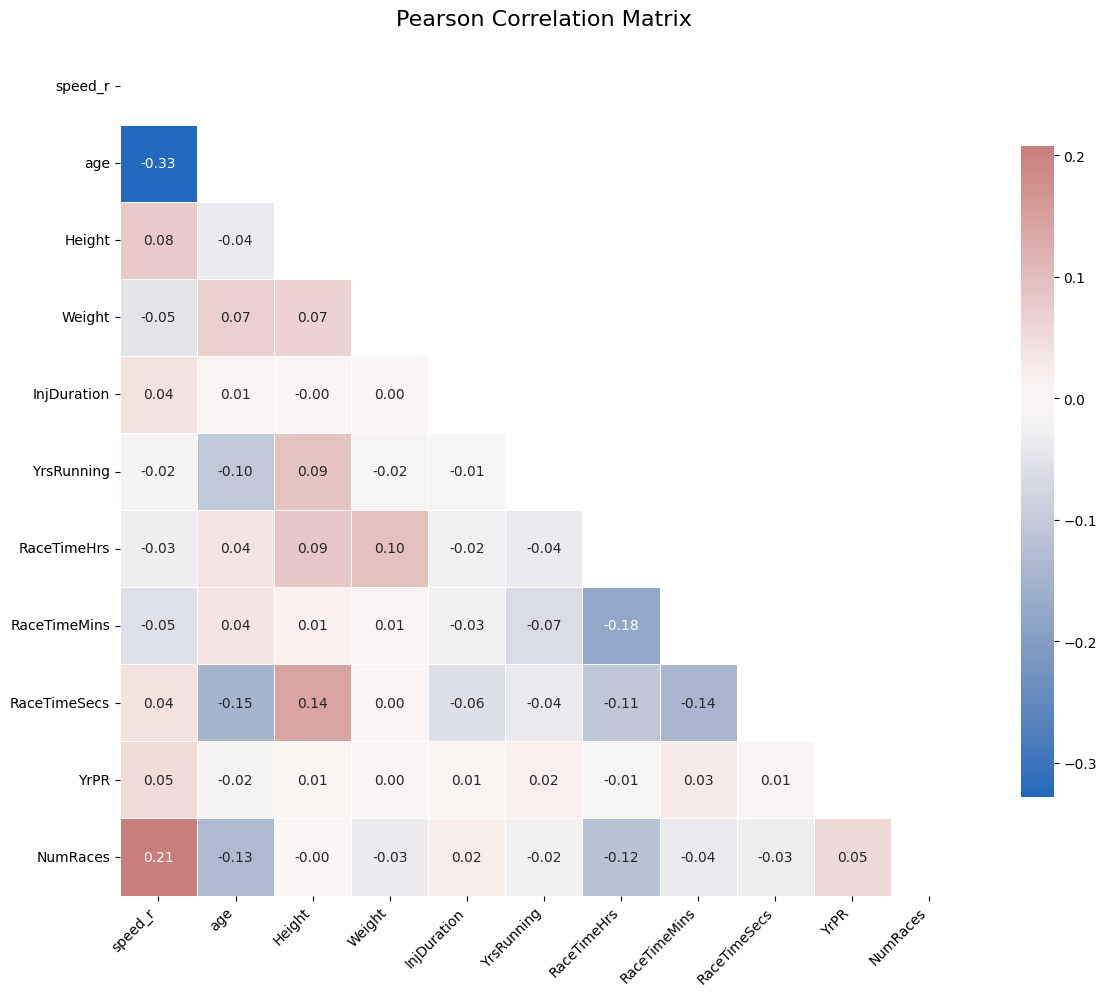

In [ ]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

# Ticks and title formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title("Pearson Correlation Matrix", fontsize=16, pad=16)

plt.tight_layout()
plt.show()


In [ ]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Compute and apply IQR capping, collect stats
rows = []
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR    = Q3 - Q1
    lower  = Q1 - 1.5 * IQR
    upper  = Q3 + 1.5 * IQR

    # count how many will be capped
    n_low  = (df[col] < lower).sum()
    n_high = (df[col] > upper).sum()

    # cap in one call
    df[col] = df[col].clip(lower, upper)

    rows.append({
        'column':        col,
        'Q1':            Q1,
        'Q3':            Q3,
        'lower_bound':   lower,
        'upper_bound':   upper,
        'capped_low':    n_low,
        'capped_high':   n_high
    })

# Show summary as a neat table
summary_df = pd.DataFrame(rows)
print("\nOutlier capping summary:")
print(
    summary_df
    .loc[:, ['column','lower_bound','upper_bound','capped_low','capped_high']]
    .to_string(index=False)
)


Outlier capping summary:
      column  lower_bound  upper_bound  capped_low  capped_high
     speed_r     1.791227     3.634929          23          139
         age     1.000000    73.000000           0            1
      Height   144.500000   199.700000           3            2
      Weight    32.700000   105.500000           1           22
 InjDuration   120.000000   120.000000         193          198
  YrsRunning    -7.000000    25.000000           0          177
 RaceTimeHrs    -2.000000     6.000000           0           11
RaceTimeMins   -20.000000    84.000000           0            2
RaceTimeSecs   -30.000000    50.000000           0           17
        YrPR  2012.000000  2012.000000         100           50
    NumRaces     4.000000     4.000000         241          221


In [ ]:
# Final overview of the preprocessed dataset
print("\n=== Preprocessed Dataset Overview ===")

# a) Shape
rows, cols = df.shape
print(f"• Shape: {rows} rows × {cols} columns")

# b) Data types
dtypes = df.dtypes.reset_index()
dtypes.columns = ['column', 'dtype']
print("\n• Column dtypes:")
print(dtypes.to_markdown(index=False))

# c) Missing values
missing = df.isnull().sum().reset_index()
missing.columns = ['column', 'missing_count']
print("\n• Missing values per column:")
print(missing.to_markdown(index=False))

# d) Sample rows
print("\n• First 5 rows:")
print(df.head().to_markdown(index=False))



=== Preprocessed Dataset Overview ===
• Shape: 1752 rows × 23 columns

• Column dtypes:
| column       | dtype   |
|:-------------|:--------|
| speed_r      | float64 |
| age          | float64 |
| Height       | float64 |
| Weight       | float64 |
| Gender       | object  |
| DominantLeg  | object  |
| InjDefn      | object  |
| InjJoint     | object  |
| InjSide      | object  |
| SpecInjury   | object  |
| InjDuration  | float64 |
| InjJoint2    | object  |
| InjSide2     | object  |
| SpecInjury2  | object  |
| Activities   | object  |
| Level        | object  |
| YrsRunning   | float64 |
| RaceDistance | object  |
| RaceTimeHrs  | float64 |
| RaceTimeMins | float64 |
| RaceTimeSecs | float64 |
| YrPR         | float64 |
| NumRaces     | float64 |

• Missing values per column:
| column       |   missing_count |
|:-------------|----------------:|
| speed_r      |               0 |
| age          |               0 |
| Height       |               0 |
| Weight       |               

In [ ]:
# Check existence
if 'InjDefn' not in df.columns:
    raise KeyError("Column 'InjDefn' not found in DataFrame.")

# Vectorized cleaning pipeline
cleaned = (
    df['InjDefn']
      .astype(str)                        # ensure string
      .str.strip()                        # trim whitespace
      .str.lower()                        # unify case
      .str.replace(r'[^\w\s]', '', regex=True)  # drop punctuation
      .replace({'nan': pd.NA})           # turn literal "nan" back to NA
)

df['InjDefn'] = cleaned

# Report
summary = (
    df['InjDefn']
      .value_counts(dropna=False)
      .rename_axis('cleaned_value')
      .reset_index(name='count')
)

print("\n‘InjDefn’ cleaning complete.  Summary of cleaned values:")
print(summary.to_markdown(index=False))


‘InjDefn’ cleaning complete.  Summary of cleaned values:
| cleaned_value                     |   count |
|:----------------------------------|--------:|
| no injury                         |     659 |
| training volumeintensity affected |     499 |
| continuing to train in pain       |     320 |
| 2 workouts missed in a row        |     274 |


## **7. Binarización de la Variable "InjDefn"**


'InjDefn' Distribution Before Binarization
| Label                             |   Frequency |
|:----------------------------------|------------:|
| no injury                         |         659 |
| training volumeintensity affected |         499 |
| continuing to train in pain       |         320 |
| 2 workouts missed in a row        |         274 |


<ipython-input-46-51b610a76ae6>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


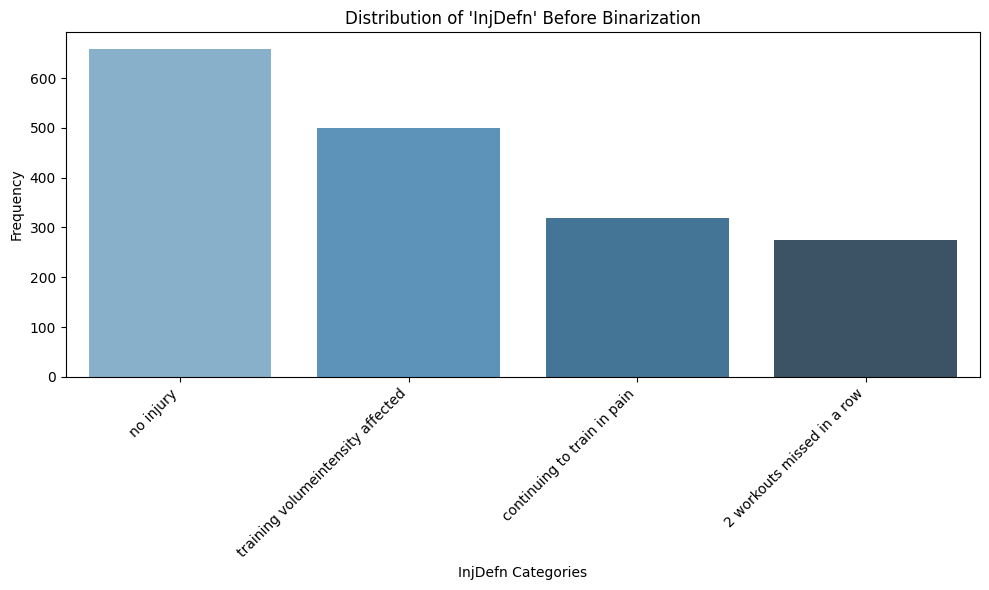

In [ ]:
# Verify that the 'InjDefn' column exists
if 'InjDefn' not in df.columns:
    raise KeyError("Column 'InjDefn' not found in the DataFrame.")

# Vectorized cleaning: trim whitespace, lowercase, remove punctuation
df['InjDefn'] = (
    df['InjDefn']
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r'[^\w\s]', '', regex=True)
        .replace({'nan': pd.NA})
)

# Build frequency table (including NaNs)
freq_table = (
    df['InjDefn']
        .value_counts(dropna=False)
        .rename_axis('Label')
        .reset_index(name='Frequency')
)

print("\n'InjDefn' Distribution Before Binarization")
print(freq_table.to_markdown(index=False))

# Plot the distribution with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=freq_table,
    x='Label',
    y='Frequency',
    palette='Blues_d'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("InjDefn Categories")
plt.ylabel("Frequency")
plt.title("Distribution of 'InjDefn' Before Binarization")
plt.tight_layout()
plt.show()



InjDefn_binary Distribution:
|   Injury |   Count |
|---------:|--------:|
|        0 |     659 |
|        1 |    1093 |


<ipython-input-57-16982409b481>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='InjDefn_binary', data=df, palette='vlag', edgecolor='k')


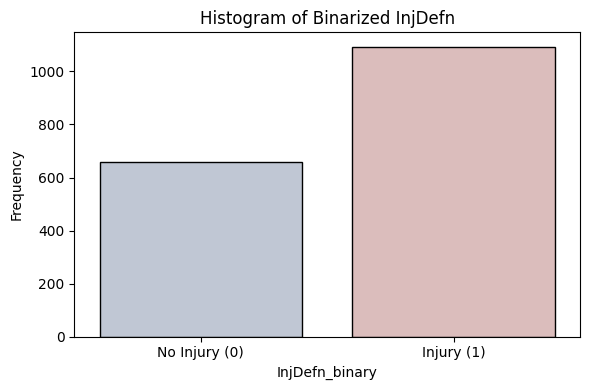

In [ ]:
# Verify column exists
if 'InjDefn' not in df.columns:
    raise KeyError("Column 'InjDefn' not found in DataFrame.")

# Clean & normalize text
clean = (
    df['InjDefn']
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r'[^\w\s]', '', regex=True)  # drop punctuation
)
clean = clean.replace('nan', pd.NA).fillna('none')
df['InjDefn'] = clean

# Define “no‑injury” labels and binarize
no_injury = {'none', 'no lesion', 'no injury', ''}
df['InjDefn_binary'] = (~clean.isin(no_injury)).astype(int)

# Print distribution as a table
dist = df['InjDefn_binary'].value_counts().sort_index().rename_axis('Injury').reset_index(name='Count')
print("\nInjDefn_binary Distribution:")
print(dist.to_markdown(index=False))

# Plot it with seaborn
plt.figure(figsize=(6, 4))
sns.countplot(x='InjDefn_binary', data=df, palette='vlag', edgecolor='k')
plt.xticks([0,1], ['No Injury (0)', 'Injury (1)'])
plt.xlabel("InjDefn_binary")
plt.ylabel("Frequency")
plt.title("Histogram of Binarized InjDefn")
plt.tight_layout()
plt.show()

### **7.1. Boxplots**

<ipython-input-55-c988365b93ab>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


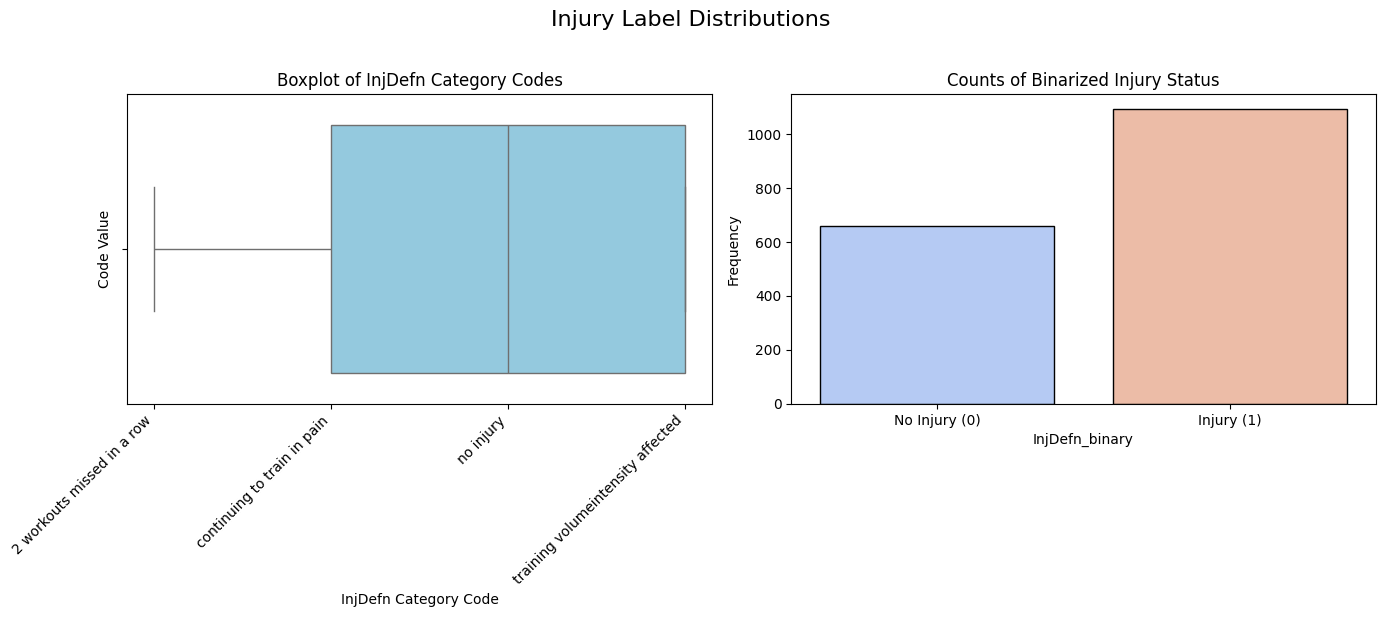

In [ ]:
# Convert 'InjDefn' to ordered categorical codes once
df['InjDefn_cat'] = df['InjDefn'].astype('category')
df['InjDefn_code'] = df['InjDefn_cat'].cat.codes

# Prepare figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# Boxplot of the category codes
sns.boxplot(
    x='InjDefn_code',
    data=df,
    ax=ax1,
    color='skyblue'
)
ax1.set_title('Boxplot of InjDefn Category Codes')
ax1.set_xlabel('InjDefn Category Code')
ax1.set_ylabel('Code Value')

# Map tick labels back to category names
labels = df['InjDefn_cat'].cat.categories.to_list()
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right')

# Countplot for the binary variable (more meaningful than a boxplot)
sns.countplot(
    x='InjDefn_binary',
    data=df,
    ax=ax2,
    palette='coolwarm',
    edgecolor='k'
)
ax2.set_title('Counts of Binarized Injury Status')
ax2.set_xlabel('InjDefn_binary')
ax2.set_ylabel('Frequency')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['No Injury (0)', 'Injury (1)'])

# Final layout tweaks
plt.suptitle('Injury Label Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


InjDefn category-to-code mapping:
| Category                          |   Code |
|:----------------------------------|-------:|
| 2 workouts missed in a row        |      0 |
| continuing to train in pain       |      1 |
| no injury                         |      2 |
| training volumeintensity affected |      3 |

Code distribution:
|   Code |   Count |
|-------:|--------:|
|      0 |     274 |
|      1 |     320 |
|      2 |     659 |
|      3 |     499 |


<ipython-input-50-8e6f19d24ee2>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


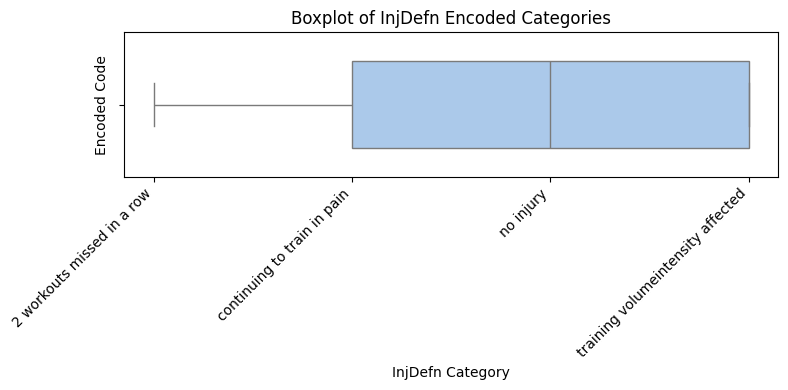

In [ ]:
# Verify column exists
if 'InjDefn' not in df.columns:
    raise KeyError("Column 'InjDefn' not found in DataFrame.")

# Clean and categorize
df['InjDefn_clean'] = (
    df['InjDefn']
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r'[^\w\s]', '', regex=True)
)
df['InjDefn_cat'] = df['InjDefn_clean'].astype('category')
df['InjDefn_code'] = df['InjDefn_cat'].cat.codes

# Print mapping table
mapping = pd.DataFrame({
    'Category': df['InjDefn_cat'].cat.categories,
    'Code':     range(len(df['InjDefn_cat'].cat.categories))
})
print("\nInjDefn category-to-code mapping:")
print(mapping.to_markdown(index=False))

# Summary of code distribution
code_dist = (
    df['InjDefn_code']
      .value_counts()
      .sort_index()
      .rename_axis('Code')
      .reset_index(name='Count')
)
print("\nCode distribution:")
print(code_dist.to_markdown(index=False))

# Boxplot of codes
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    x='InjDefn_code',
    data=df,
    ax=ax,
    palette='pastel',
    width=0.6
)
ax.set_xticks(mapping['Code'])
ax.set_xticklabels(mapping['Category'], rotation=45, ha='right')
ax.set_xlabel("InjDefn Category")
ax.set_ylabel("Encoded Code")
ax.set_title("Boxplot of InjDefn Encoded Categories")
plt.tight_layout()
plt.show()


### **7.2. Visualización t-SNE**


Missing values by feature:
| feature      |   missing_count |
|:-------------|----------------:|
| speed_r      |               0 |
| age          |               0 |
| Height       |               0 |
| Weight       |               0 |
| InjDuration  |               0 |
| YrsRunning   |               0 |
| RaceTimeHrs  |            1197 |
| RaceTimeMins |            1051 |
| RaceTimeSecs |            1307 |
| YrPR         |               0 |
| NumRaces     |               0 |
| InjDefn_code |               0 |
| TSNE_1       |               0 |
| TSNE_2       |               0 |


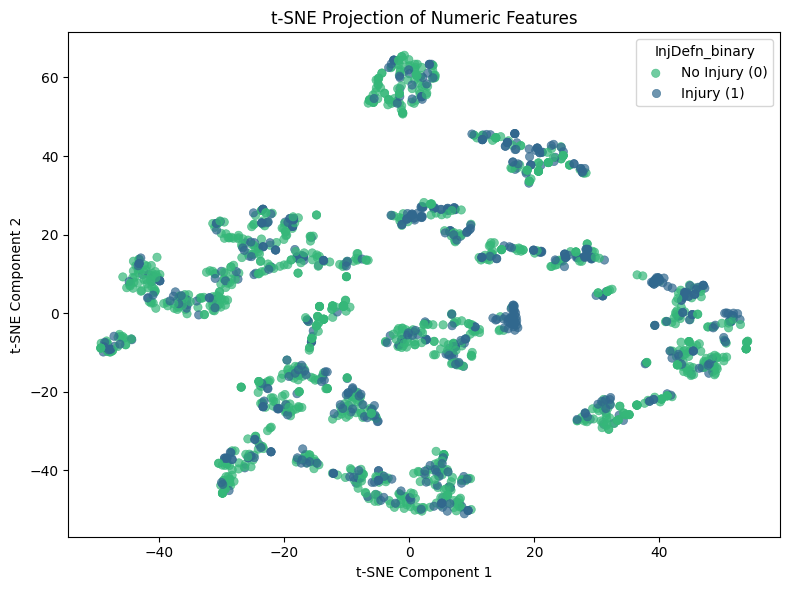

In [ ]:
# Select numeric features (drop the binary target)
numeric_cols = (
    df
    .select_dtypes(include=[np.number])
    .columns
    .drop('InjDefn_binary', errors='ignore')
)
X_num = df[numeric_cols]

# Summarize missing values
missing = (
    X_num.isnull()
         .sum()
         .reset_index()
         .rename(columns={'index': 'feature', 0: 'missing_count'})
)
print("\nMissing values by feature:")
print(missing.to_markdown(index=False))

# Impute missing values (mean strategy)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X_num), columns=numeric_cols)

# Compute t‑SNE embedding (no PCA step)
tsne = TSNE(
    n_components=2,
    init='random',
    learning_rate='auto',
    perplexity=30,
    random_state=42
)
tsne_results = tsne.fit_transform(X_imputed)

# Attach t‑SNE coordinates back to the DataFrame
df['TSNE_1'], df['TSNE_2'] = tsne_results[:, 0], tsne_results[:, 1]

# Plot the t‑SNE projection
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TSNE_1', y='TSNE_2',
    hue='InjDefn_binary',
    data=df,
    palette='viridis',
    alpha=0.7,
    edgecolor=None
)
plt.title('t‑SNE Projection of Numeric Features')
plt.xlabel('t‑SNE Component 1')
plt.ylabel('t‑SNE Component 2')
plt.legend(
    title='InjDefn_binary',
    labels=['No Injury (0)', 'Injury (1)'],
    loc='best'
)
plt.tight_layout()
plt.show()

## **8. Shallow Learning Models**

### **8.1. Random Forest**

#### **8.1.1 Random Forest with 75**

##### **Architecture:**


---

The 75-tree Random Forest comprises 75 independent decision trees, each trained on a bootstrap sample. Splits are determined by minimizing Gini impurity, with √(p) randomly selected features considered at each node, introducing feature-level randomness. Trees are grown to full depth, halting only when leaves are pure or contain fewer than two samples, enabling them to model complex patterns. During inference, each tree produces class probabilities, which are averaged to assign the final label—reducing variance via majority voting.

Random Forest with 75 estimators
--------------------------------------------------
Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        76

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

Accuracy : 1.0000
AUC      : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
--------------------------------------------------
Fold 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        77

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

Accuracy : 1.0000
AUC      : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
-----------------

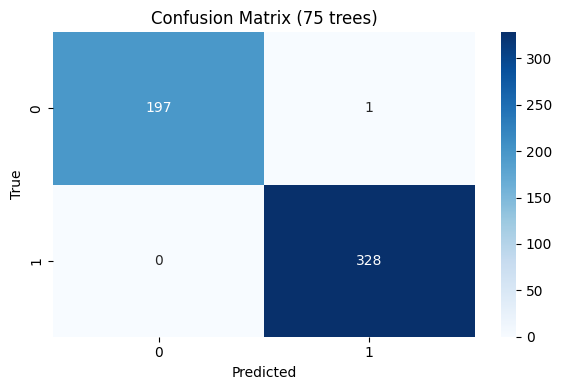

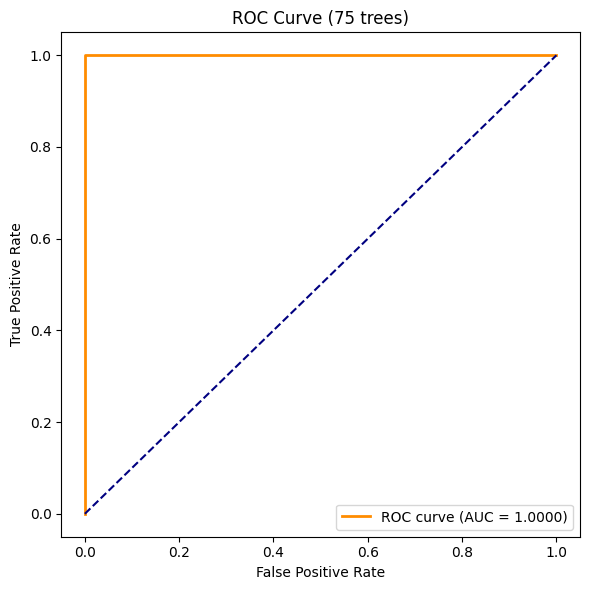

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, precision_score, recall_score, f1_score
)

# Features & target

X = df.drop(columns=['InjDefn', 'InjDefn_binary'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)             # one‑hot
y = df['InjDefn_binary']

# 3. Cross‑validation (10 folds) – 75 trees
n_estimators = 75
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_acc, fold_auc, fold_prec, fold_rec, fold_f1 = [], [], [], [], []

print("Random Forest with 75 estimators")
print("-" * 50)

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, X_val   = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val   = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_tr, y_tr)

    y_pred       = model.predict(X_val)
    y_proba      = model.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_pred)
    auc_ = roc_auc_score(y_val, y_proba)
    pre  = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)

    fold_acc.append(acc); fold_auc.append(auc_)
    fold_prec.append(pre); fold_rec.append(rec); fold_f1.append(f1)

    print(f"Fold {fold}")
    print(classification_report(y_val, y_pred))
    print(f"Accuracy : {acc:.4f}")
    print(f"AUC      : {auc_:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print("-" * 50)

# Summary (mean ± SD, six decimals)
mean_acc  = np.mean(fold_acc);   sd_acc  = np.std(fold_acc,  ddof=1)
mean_auc  = np.mean(fold_auc);   sd_auc  = np.std(fold_auc,  ddof=1)
mean_pre  = np.mean(fold_prec);  sd_pre  = np.std(fold_prec, ddof=1)
mean_rec  = np.mean(fold_rec);   sd_rec  = np.std(fold_rec,  ddof=1)
mean_f1   = np.mean(fold_f1);    sd_f1   = np.std(fold_f1,   ddof=1)

summary_75 = pd.DataFrame({
    "Metric":   ["Mean Score", "Mean AUC", "Mean Accuracy",
                 "Mean Precision", "Mean Recall", "Mean F1"],
    "Mean":     [mean_acc, mean_auc, mean_acc, mean_pre, mean_rec, mean_f1],
    "±":        [sd_acc,   sd_auc,  sd_acc,  sd_pre,  sd_rec,  sd_f1]
})

print("\nSummary table of average metrics (10‑Fold CV, 75 trees):")
print(summary_75.to_string(index=False, formatters={
        "Mean": "{:.6f}".format,
        "±":    "{:.6f}".format
}))

# Final model on full training set

rf_final = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
rf_final.fit(X_train, y_train)

y_test_pred       = rf_final.predict(X_test)
y_test_proba      = rf_final.predict_proba(X_test)[:, 1]

print("\nTest‑set classification report (75 trees):")
print(classification_report(y_test, y_test_pred))
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test AUC     : {roc_auc_score(y_test, y_test_proba):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (75 trees)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc      = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (75 trees)"); plt.legend(); plt.tight_layout(); plt.show()


#### **8.1.2. Random Forest with 100**

##### **Architecture:**


---

The 100-tree Random Forest uses identical hyperparameters but expands the ensemble to 100 trees. This increase typically enhances generalization by reducing noise through a larger, more diverse ensemble. The benefits come at a proportional cost in training time, memory usage, and inference latency, though these remain manageable for standard tabular datasets.

Random Forest with 100 estimators
--------------------------------------------------
Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        76

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

Accuracy : 1.0000
AUC      : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
--------------------------------------------------
Fold 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        77

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

Accuracy : 1.0000
AUC      : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
----------------

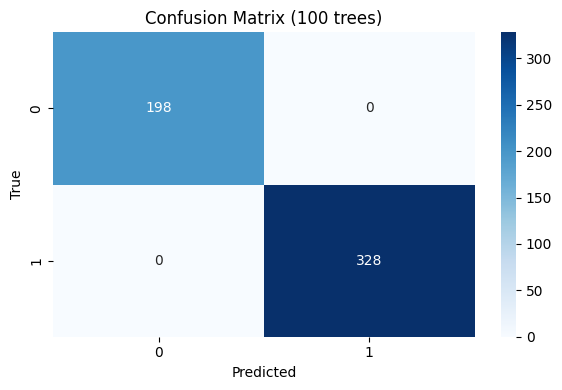

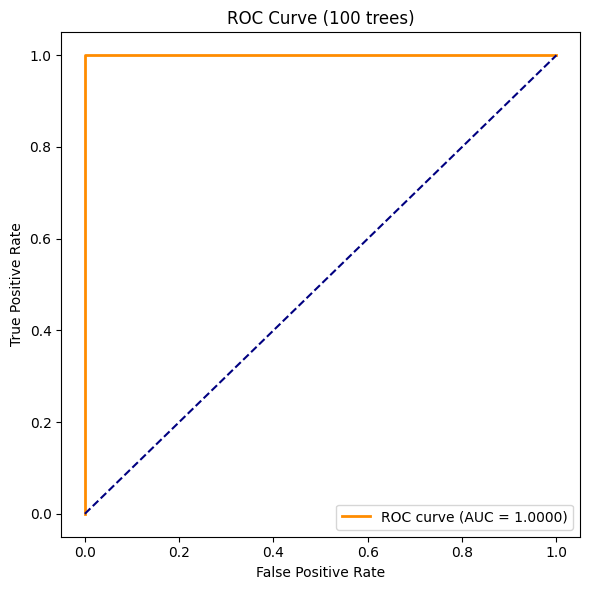

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, precision_score, recall_score, f1_score
)

# Features & target
X = df.drop(columns=['InjDefn', 'InjDefn_binary'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)
y = df['InjDefn_binary']


# Cross‑validation (10 folds) – 100 trees
n_estimators = 100
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_acc, fold_auc, fold_prec, fold_rec, fold_f1 = [], [], [], [], []

print("Random Forest with 100 estimators")
print("-" * 50)

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, X_val   = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val   = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_tr, y_tr)

    y_pred  = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_pred)
    auc_ = roc_auc_score(y_val, y_proba)
    pre  = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)

    fold_acc.append(acc); fold_auc.append(auc_)
    fold_prec.append(pre); fold_rec.append(rec); fold_f1.append(f1)

    print(f"Fold {fold}")
    print(classification_report(y_val, y_pred))
    print(f"Accuracy : {acc:.4f}")
    print(f"AUC      : {auc_:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print("-" * 50)

# Summary (mean ± SD, six decimals)
mean_acc  = np.mean(fold_acc);   sd_acc  = np.std(fold_acc,  ddof=1)
mean_auc  = np.mean(fold_auc);   sd_auc  = np.std(fold_auc,  ddof=1)
mean_pre  = np.mean(fold_prec);  sd_pre  = np.std(fold_prec, ddof=1)
mean_rec  = np.mean(fold_rec);   sd_rec  = np.std(fold_rec,  ddof=1)
mean_f1   = np.mean(fold_f1);    sd_f1   = np.std(fold_f1,   ddof=1)

summary_100 = pd.DataFrame({
    "Metric": ["Mean Score", "Mean AUC", "Mean Accuracy",
               "Mean Precision", "Mean Recall", "Mean F1"],
    "Mean":   [mean_acc, mean_auc, mean_acc, mean_pre, mean_rec, mean_f1],
    "±":      [sd_acc,   sd_auc,  sd_acc,  sd_pre,  sd_rec,  sd_f1]
})

print("\nSummary table of average metrics (10‑Fold CV, 100 trees):")
print(summary_100.to_string(index=False, formatters={
        "Mean": "{:.6f}".format,
        "±":    "{:.6f}".format
}))

# Final model on full training set
rf_final = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
rf_final.fit(X_train, y_train)

y_test_pred  = rf_final.predict(X_test)
y_test_proba = rf_final.predict_proba(X_test)[:, 1]

print("\nTest‑set classification report (100 trees):")
print(classification_report(y_test, y_test_pred))
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test AUC     : {roc_auc_score(y_test, y_test_proba):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (100 trees)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc      = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (100 trees)"); plt.legend(); plt.tight_layout(); plt.show()


#### **8.1.3. Random Forest with 125**

##### **Architecture:**


---

The 125-tree Random Forest further increases the ensemble size to 125 trees while maintaining default hyperparameters (bootstrap=True, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt'). This model tends to achieve the best accuracy or AUC, benefiting from even lower variance at the cost of higher computational and storage demands. Prediction still involves averaging class probabilities across all trees to determine the final output.

Random Forest with 125 estimators
--------------------------------------------------
Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        76

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

Accuracy : 1.0000
AUC      : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
--------------------------------------------------
Fold 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        77

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

Accuracy : 1.0000
AUC      : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
----------------

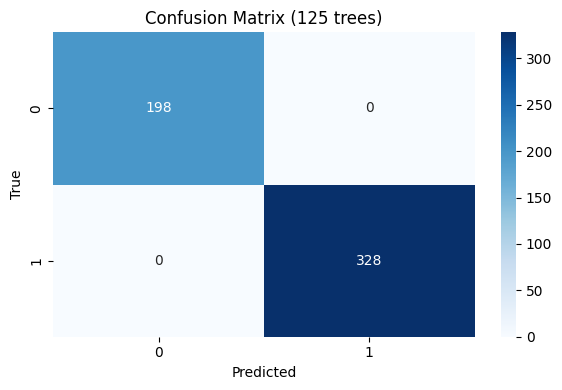

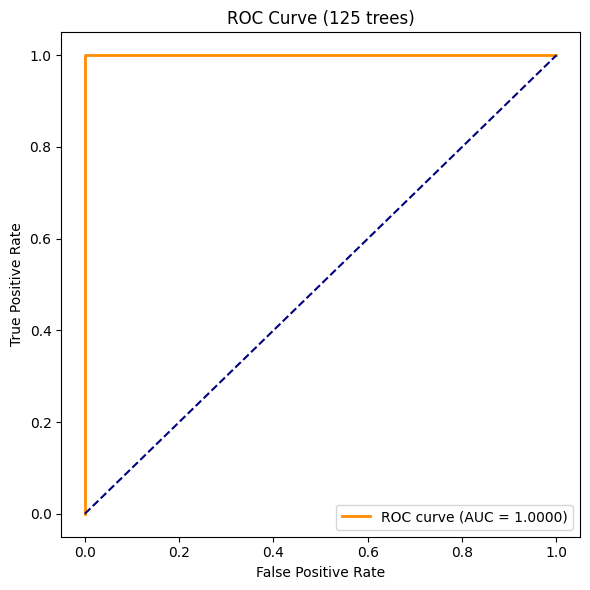

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, precision_score, recall_score, f1_score
)


# Features & target

X = df.drop(columns=['InjDefn', 'InjDefn_binary'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)      # one‑hot encode categoricals
y = df['InjDefn_binary']

# Stratified 10‑fold CV – 125 estimators
n_estimators = 125
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_acc, fold_auc, fold_prec, fold_rec, fold_f1 = [], [], [], [], []

print("Random Forest with 125 estimators")
print("-" * 50)

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_tr, y_tr)

    y_pred  = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_pred)
    auc_ = roc_auc_score(y_val, y_proba)
    pre  = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)

    fold_acc.append(acc); fold_auc.append(auc_)
    fold_prec.append(pre); fold_rec.append(rec); fold_f1.append(f1)

    print(f"Fold {fold}")
    print(classification_report(y_val, y_pred))
    print(f"Accuracy : {acc:.4f}")
    print(f"AUC      : {auc_:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print("-" * 50)

# 4. CV summary (mean ± SD, six decimals)
mean_acc  = np.mean(fold_acc);  sd_acc  = np.std(fold_acc,  ddof=1)
mean_auc  = np.mean(fold_auc);  sd_auc  = np.std(fold_auc,  ddof=1)
mean_pre  = np.mean(fold_prec); sd_pre  = np.std(fold_prec, ddof=1)
mean_rec  = np.mean(fold_rec);  sd_rec  = np.std(fold_rec,  ddof=1)
mean_f1   = np.mean(fold_f1);   sd_f1   = np.std(fold_f1,   ddof=1)

summary_125 = pd.DataFrame({
    "Metric": ["Mean Score", "Mean AUC", "Mean Accuracy",
               "Mean Precision", "Mean Recall", "Mean F1"],
    "Mean":   [mean_acc, mean_auc, mean_acc, mean_pre, mean_rec, mean_f1],
    "±":      [sd_acc,   sd_auc,  sd_acc,  sd_pre,  sd_rec,  sd_f1]
})

print("\nSummary table of average metrics (10‑Fold CV, 125 trees):")
print(summary_125.to_string(index=False, formatters={
        "Mean": "{:.6f}".format,
        "±":    "{:.6f}".format
}))

# Final model on the full training set
rf_final = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
rf_final.fit(X_train, y_train)

y_test_pred  = rf_final.predict(X_test)
y_test_proba = rf_final.predict_proba(X_test)[:, 1]

print("\nTest‑set classification report (125 trees):")
print(classification_report(y_test, y_test_pred))
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test AUC     : {roc_auc_score(y_test, y_test_proba):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (125 trees)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc      = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (125 trees)")
plt.legend(loc="lower right")
plt.tight_layout(); plt.show()



#### **8.2. MLP**

In [ ]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=r"Found unknown categories in columns",
    category=UserWarning,
    module="sklearn.preprocessing._encoders"
)
# Split features and target
X = df.drop(columns=['InjDefn', 'InjDefn_binary'], errors='ignore')
y = df['InjDefn_binary']

# Detect numeric vs categorical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Build preprocessing transformer
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])


# Stratified 70-30 train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Fit transformer on training data, apply to both sets
X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

# Report final input dimension
input_dim = X_train.shape[1]
print(f"Input dimension after one-hot, imputation and scaling: {input_dim}")


Input dimension after one-hot, imputation and scaling: 779


#### **8.2.1 MLP 1**

##### **Architecture:**


---

MLP 1 is a fully connected neural network architecture composed of two hidden layers, designed to process input vectors whose dimensionality matches that of the feature space. The first hidden layer consists of twice as many neurons as the input dimension, thereby allowing for an initial expansion in representational capacity. The second hidden layer reverts to a neuron count equal to the input dimensionality, potentially refining the feature representation. Both layers employ the Rectified Linear Unit (ReLU) as the activation function, facilitating non-linear transformations while maintaining computational efficiency. The network concludes with a softmax-activated output layer comprising two units, which produces normalized class probabilities for binary classification. Training is conducted using the Adam optimization algorithm with a learning rate of 1e-4, minimizing the categorical crossentropy loss function.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 → Loss: 0.0144, Acc: 0.9922, AUC: 1.0000, Prec: 0.9880, Rec: 1.0000, F1: 0.9939


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 → Loss: 0.0145, Acc: 0.9922, AUC: 1.0000, Prec: 1.0000, Rec: 0.9872, F1: 0.9935


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 → Loss: 0.0010, Acc: 1.0000, AUC: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4 → Loss: 0.0533, Acc: 0.9844, AUC: 0.9990, Prec: 0.9873, Rec: 0.9873, F1: 0.9873
Fold 5 → Loss: 0.0120, Acc: 1.0000, AUC: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6 → Loss: 0.0406, Acc: 0.9844, AUC: 0.9997, Prec: 1.0000, Rec: 0.9747, F1: 0.9872


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7 → Loss: 0.0002, Acc: 1.0000, AUC: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8 → Loss: 0.0415, Acc: 0.9844, AUC: 0.9992, Prec: 1.0000, Rec: 0.9730, F1: 0.9863


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9 → Loss: 0.0052, Acc: 1.0000, AUC: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10 → Loss: 0.0364, Acc: 0.9922, AUC: 1.0000, Prec: 1.0000, Rec: 0.9880, F1: 0.9939

Resultados por fold:
 Fold  Epochs  Val_Loss  Keras_Acc  Accuracy      AUC  Precision   Recall       F1
    1     523  0.014428   0.992248  0.992248 1.000000   0.987952 1.000000 0.993939
    2      92  0.014470   0.992248  0.992248 1.000000   1.000000 0.987179 0.993548
    3     680  0.001004   1.000000  1.000000 1.000000   1.000000 1.000000 1.000000
    4     345  0.053282   0.984375  0.984375 0.998967   0.987342 0.987342 0.987342
    5     241  0.011964   1.000000  1.000000 1.000000   1.000000 1.000000 1.000000
    6     105  0.040616   0.984375  0.984375 0.999742   1.000000 0.974684 0.987179
    7    1000  0.000244   1.000000  1.000000 1.000000   1.000000 1.000000 1.000000
    8     273  0.041473   0.984375  0.984375 0.999249   1.000000 0.972973 0.986301
    9     665  0.005198   1.000000  1.000000 1.000000   1.000000 1.000000 1.000000
   10      40  0.036431   0.992188  0.992188 1.000000   1.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6899 - loss: 0.5914 - val_accuracy: 0.9027 - val_loss: 0.2809
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9795 - loss: 0.1303 - val_accuracy: 0.9339 - val_loss: 0.1827
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9990 - loss: 0.0432 - val_accuracy: 0.9728 - val_loss: 0.1347
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9988 - loss: 0.0237 - val_accuracy: 0.9650 - val_loss: 0.1124
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9998 - loss: 0.0169 - val_accuracy: 0.9728 - val_loss: 0.0942
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9996 - loss: 0.0104 - val_accuracy: 0.9767 - val_loss: 0.0831
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.9767 - val_loss: 0.0748
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9805 

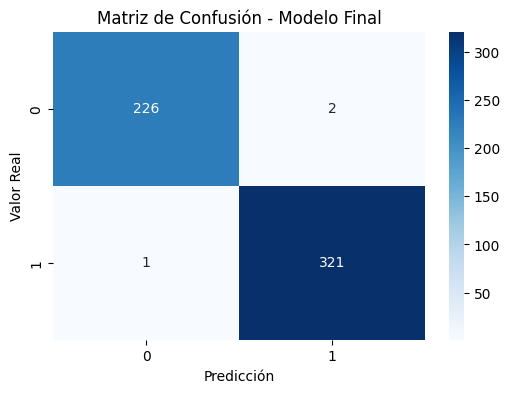

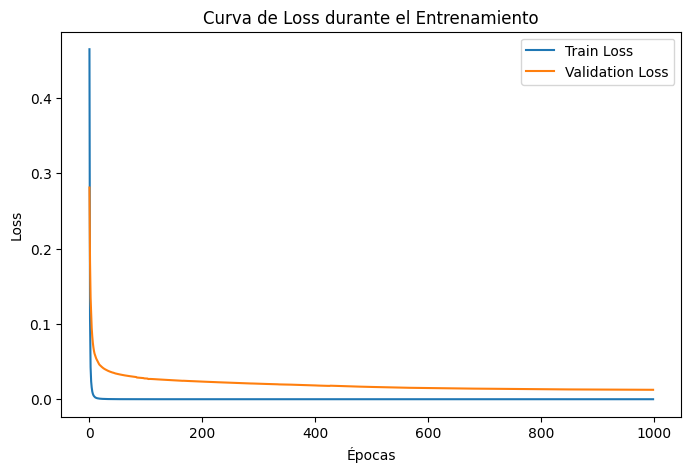

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)


if not isinstance(X_train, np.ndarray):
    X_train = X_train.values
if not isinstance(y_train, np.ndarray):
    y_train = y_train.values
if not isinstance(X_test, np.ndarray):
    X_test = X_test.values
if not isinstance(y_test, np.ndarray):
    y_test = y_test.values

# Para usar categorical crossentropy con softmax en un problema binario:
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat  = to_categorical(y_test,  num_classes=2)

# Definir input_dim a partir del número de características
input_dim = X_train.shape[1]

def create_model(input_dim, num_classes=2):
    model = Sequential()
    model.add(Dense(2 * input_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# --- K-Fold Cross Validation (10 folds) ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []
fold_no = 1

for train_index, val_index in kf.split(X_train):
    X_fold_train = X_train[train_index]
    X_fold_val   = X_train[val_index]
    y_fold_train = y_train_cat[train_index]
    y_fold_val   = y_train_cat[val_index]

    model = create_model(input_dim)
    history = model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluación Keras
    loss, keras_acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)

    # Predicciones
    y_val_prob = model.predict(X_fold_val, verbose=0)
    y_val_pred = np.argmax(y_val_prob, axis=1)
    y_val_true = np.argmax(y_fold_val, axis=1)

    # Métricas sklearn
    acc   = accuracy_score(y_val_true, y_val_pred)
    auc   = roc_auc_score(y_val_true, y_val_prob[:,1])
    prec  = precision_score(y_val_true, y_val_pred)
    rec   = recall_score(y_val_true, y_val_pred)
    f1    = f1_score(y_val_true, y_val_pred)

    fold_results.append({
        "Fold": fold_no,
        "Epochs": len(history.history['loss']),
        "Val_Loss": loss,
        "Keras_Acc": keras_acc,
        "Accuracy": acc,
        "AUC": auc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

    print(f"Fold {fold_no} → Loss: {loss:.4f}, Acc: {acc:.4f}, "
          f"AUC: {auc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
    fold_no += 1

# Resultados por fold
results_df = pd.DataFrame(fold_results)
print("\nResultados por fold:")
print(results_df.to_string(index=False))

# -----------------------------
# Cálculo de métricas promedio y desviación estándar
stats = results_df[[
    "Val_Loss", "Keras_Acc",
    "Accuracy", "AUC",
    "Precision", "Recall", "F1"
]]
summary = stats.agg(["mean", "std"]).transpose().reset_index()
summary.columns = ["Métrica", "Promedio", "Desviación estándar"]

print("\nMétricas promedio y SD (10 folds):")
print(summary.to_markdown(index=False, floatfmt=".4f"))

# -----------------------------
# Entrenamiento final con todo el set de entrenamiento
final_model = create_model(input_dim)
history_final = final_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluación en test
loss_test, acc_test = final_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nModelo final - Loss test: {loss_test:.4f}, Accuracy test: {acc_test:.4f}")

# Matriz de confusión
y_pred_prob = final_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Modelo Final')
plt.show()

# Curva de Loss
plt.figure(figsize=(8, 5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Loss durante el Entrenamiento')
plt.legend()
plt.show()


#### **8.2.2. MLP 2**

##### **Architecture:**


---



MLP 2 maintains the two-hidden-layer structure and ReLU activations but adopts a different neuron allocation strategy. Specifically, the first hidden layer is composed of half the number of neurons relative to the input dimensionality, which enforces an early compression of the feature space. The second hidden layer restores the neuron count to match the input dimension, potentially enabling re-expansion and re-integration of learned representations. As in MLP 1, a softmax output layer with two units is used to generate probabilistic class predictions. Model training follows the same optimization scheme: Adam with a fixed learning rate of 1e-4 and categorical crossentropy as the objective function.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 → Loss: 0.0109, Acc: 1.0000, AUC: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 → Loss: 0.0198, Acc: 0.9922, AUC: 0.9997, Prec: 1.0000, Rec: 0.9872, F1: 0.9935


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 → Loss: 0.0285, Acc: 0.9922, AUC: 0.9998, Prec: 1.0000, Rec: 0.9855, F1: 0.9927


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4 → Loss: 0.1070, Acc: 0.9766, AUC: 0.9959, Prec: 1.0000, Rec: 0.9620, F1: 0.9806


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5 → Loss: 0.0817, Acc: 0.9766, AUC: 0.9959, Prec: 0.9868, Rec: 0.9740, F1: 0.9804


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6 → Loss: 0.0839, Acc: 0.9688, AUC: 0.9956, Prec: 0.9870, Rec: 0.9620, F1: 0.9744


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7 → Loss: 0.0333, Acc: 0.9766, AUC: 1.0000, Prec: 1.0000, Rec: 0.9595, F1: 0.9793


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8 → Loss: 0.0710, Acc: 0.9688, AUC: 0.9982, Prec: 0.9730, Rec: 0.9730, F1: 0.9730


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9 → Loss: 0.1169, Acc: 0.9531, AUC: 0.9952, Prec: 0.9861, Rec: 0.9342, F1: 0.9595


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10 → Loss: 0.0992, Acc: 0.9688, AUC: 0.9973, Prec: 1.0000, Rec: 0.9518, F1: 0.9753

Resultados por fold:
 Fold  Epochs  Val_Loss  Keras_Acc  Accuracy      AUC  Precision   Recall       F1
    1    1000  0.010947   1.000000  1.000000 1.000000   1.000000 1.000000 1.000000
    2     773  0.019777   0.992248  0.992248 0.999749   1.000000 0.987179 0.993548
    3     744  0.028516   0.992188  0.992188 0.999754   1.000000 0.985507 0.992701
    4      91  0.107010   0.976562  0.976562 0.995867   1.000000 0.962025 0.980645
    5      64  0.081734   0.976562  0.976562 0.995926   0.986842 0.974026 0.980392
    6      55  0.083921   0.968750  0.968750 0.995608   0.987013 0.962025 0.974359
    7      74  0.033350   0.976562  0.976562 1.000000   1.000000 0.959459 0.979310
    8    1000  0.070965   0.968750  0.968750 0.998248   0.972973 0.972973 0.972973
    9      59  0.116910   0.953125  0.953125 0.995192   0.986111 0.934211 0.959459
   10     100  0.099159   0.968750  0.968750 0.997323   1.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6048 - loss: 0.6621 - val_accuracy: 0.8366 - val_loss: 0.4715
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8934 - loss: 0.3533 - val_accuracy: 0.8949 - val_loss: 0.3490
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9752 - loss: 0.1918 - val_accuracy: 0.9066 - val_loss: 0.2794
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9868 - loss: 0.1176 - val_accuracy: 0.9105 - val_loss: 0.2462
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9933 - loss: 0.0726 - val_accuracy: 0.9066 - val_loss: 0.2128
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9970 - loss: 0.0428 - val_accuracy: 0.9222 - val_loss: 0.1946
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9943 - loss: 0.0333 - val_accuracy: 0.9222 - val_loss: 0.1766
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9974 - loss: 0.0261 - val_accuracy: 0.9300 

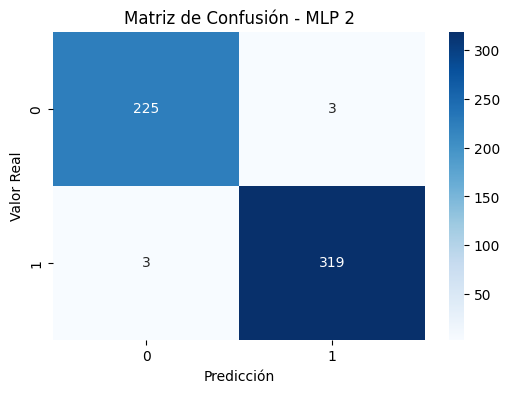

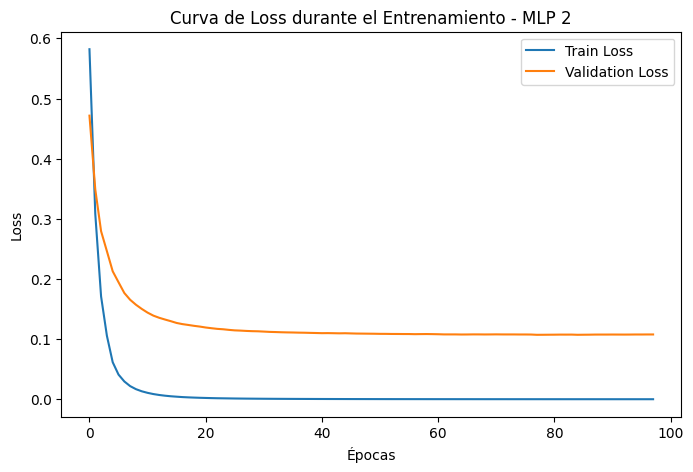

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical  # Para convertir etiquetas a one-hot

from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)

if not isinstance(X_train, np.ndarray):
    X_train = X_train.values
if not isinstance(y_train, np.ndarray):
    y_train = y_train.values
if not isinstance(X_test, np.ndarray):
    X_test = X_test.values
if not isinstance(y_test, np.ndarray):
    y_test = y_test.values

# One‑hot para categorical_crossentropy (problema binario)
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat  = to_categorical(y_test,  num_classes=2)

# Input dimension
input_dim = X_train.shape[1]
# Tamaño primera capa oculta = 50% de input_dim
hidden1_mlp2 = max(1, int(0.5 * input_dim))

def create_mlp2_model(input_dim):
    model = Sequential()
    model.add(Dense(hidden1_mlp2, input_dim=input_dim, activation='relu'))
    model.add(Dense(input_dim, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# --- K-Fold Cross Validation (10 folds) ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []
fold_no = 1

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train_cat[train_index], y_train_cat[val_index]

    model = create_mlp2_model(input_dim)
    history = model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluación Keras
    loss, keras_acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)

    # Predicciones para métricas adicionales
    y_val_prob = model.predict(X_fold_val, verbose=0)
    y_val_pred = np.argmax(y_val_prob, axis=1)
    y_val_true = np.argmax(y_fold_val, axis=1)

    # Métricas sklearn
    acc   = accuracy_score(y_val_true, y_val_pred)
    auc   = roc_auc_score(y_val_true, y_val_prob[:,1])
    prec  = precision_score(y_val_true, y_val_pred)
    rec   = recall_score(y_val_true, y_val_pred)
    f1    = f1_score(y_val_true, y_val_pred)

    fold_results.append({
        "Fold": fold_no,
        "Epochs": len(history.history['loss']),
        "Val_Loss": loss,
        "Keras_Acc": keras_acc,
        "Accuracy": acc,
        "AUC": auc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

    print(f"Fold {fold_no} → Loss: {loss:.4f}, Acc: {acc:.4f}, "
          f"AUC: {auc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
    fold_no += 1

# DataFrame de resultados por fold
results_df = pd.DataFrame(fold_results)
print("\nResultados por fold:")
print(results_df.to_string(index=False))

# -----------------------------
# Tabla resumen: promedio y desviación estándar
stats = results_df[[
    "Val_Loss", "Keras_Acc",
    "Accuracy", "AUC",
    "Precision", "Recall", "F1"
]]
summary = stats.agg(["mean", "std"]).transpose().reset_index()
summary.columns = ["Métrica", "Promedio", "Desviación estándar"]

print("\nMétricas promedio y SD (10 folds):")
print(summary.to_markdown(index=False, floatfmt=".4f"))

# -------------------------------------------------------------------
# Entrenamiento final con todo el set de entrenamiento
final_model = create_mlp2_model(input_dim)
history_final = final_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluación en test
loss_test, acc_test = final_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nMLP 2 - Loss test: {loss_test:.4f}, Accuracy test: {acc_test:.4f}")

# Reporte y matriz de confusión en test
y_pred_prob = final_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nReporte de Clasificación en test:")
print(classification_report(y_true, y_pred))

cm2 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - MLP 2')
plt.show()

# Curva de Loss
plt.figure(figsize=(8, 5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Loss durante el Entrenamiento - MLP 2')
plt.legend()
plt.show()


#### **8.2.3. MLP 3**

##### **Architecture:**


---

MLP 3 introduces a more aggressive reduction strategy across its architecture. The first hidden layer contains half the number of neurons of the input layer, and the second hidden layer further halves that amount, resulting in a significant bottleneck. This compression may encourage the model to extract highly salient features, albeit at the risk of underfitting if the reduction is too severe. ReLU remains the activation function for both layers, preserving consistency across the network family. The model ends with a two-unit softmax output layer for binary classification, and is trained identically to the previous models using the Adam optimizer (learning rate = 1e-4) and categorical crossentropy loss.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 → Loss: 0.0540, Acc: 0.9767, AUC: 0.9990, Prec: 1.0000, Rec: 0.9634, F1: 0.9814


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 → Loss: 0.0037, Acc: 1.0000, AUC: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 → Loss: 0.0273, Acc: 0.9922, AUC: 0.9990, Prec: 1.0000, Rec: 0.9855, F1: 0.9927


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4 → Loss: 0.0867, Acc: 0.9844, AUC: 0.9974, Prec: 0.9873, Rec: 0.9873, F1: 0.9873


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5 → Loss: 0.0690, Acc: 0.9766, AUC: 0.9967, Prec: 0.9868, Rec: 0.9740, F1: 0.9804


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6 → Loss: 0.0647, Acc: 0.9766, AUC: 1.0000, Prec: 1.0000, Rec: 0.9620, F1: 0.9806


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7 → Loss: 0.0005, Acc: 1.0000, AUC: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8 → Loss: 0.0825, Acc: 0.9766, AUC: 0.9960, Prec: 0.9733, Rec: 0.9865, F1: 0.9799


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9 → Loss: 0.0653, Acc: 0.9766, AUC: 0.9987, Prec: 0.9867, Rec: 0.9737, F1: 0.9801


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10 → Loss: 0.1248, Acc: 0.9609, AUC: 0.9941, Prec: 0.9756, Rec: 0.9639, F1: 0.9697

Resultados por fold:
 Fold  Epochs  Val_Loss  Keras_Acc  Accuracy      AUC  Precision   Recall       F1
    1     209  0.054041   0.976744  0.976744 0.998962   1.000000 0.963415 0.981366
    2     867  0.003731   1.000000  1.000000 1.000000   1.000000 1.000000 1.000000
    3     205  0.027338   0.992188  0.992188 0.999017   1.000000 0.985507 0.992701
    4     664  0.086652   0.984375  0.984375 0.997417   0.987342 0.987342 0.987342
    5      70  0.068988   0.976562  0.976562 0.996690   0.986842 0.974026 0.980392
    6     264  0.064651   0.976562  0.976562 1.000000   1.000000 0.962025 0.980645
    7    1000  0.000462   1.000000  1.000000 1.000000   1.000000 1.000000 1.000000
    8     742  0.082541   0.976562  0.976562 0.995996   0.973333 0.986486 0.979866
    9     434  0.065258   0.976562  0.976562 0.998735   0.986667 0.973684 0.980132
   10     177  0.124782   0.960938  0.960938 0.994110   0.97

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4677 - loss: 0.9418 - val_accuracy: 0.7704 - val_loss: 0.5648
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8250 - loss: 0.4951 - val_accuracy: 0.8444 - val_loss: 0.4450
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9239 - loss: 0.3202 - val_accuracy: 0.8755 - val_loss: 0.3699
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9707 - loss: 0.2064 - val_accuracy: 0.8911 - val_loss: 0.3171
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9924 - loss: 0.1498 - val_accuracy: 0.9183 - val_loss: 0.2799
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9940 - loss: 0.1035 - val_accuracy: 0.9300 - val_loss: 0.2484
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9986 - loss: 0.0694 - val_accuracy: 0.9416 - val_loss: 0.2255
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9974 - loss: 0.0536 - val_accuracy: 0.9416 

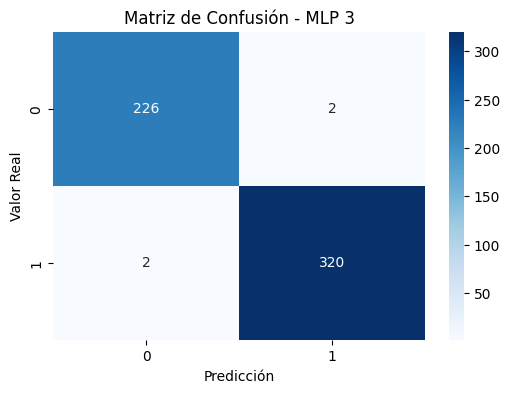

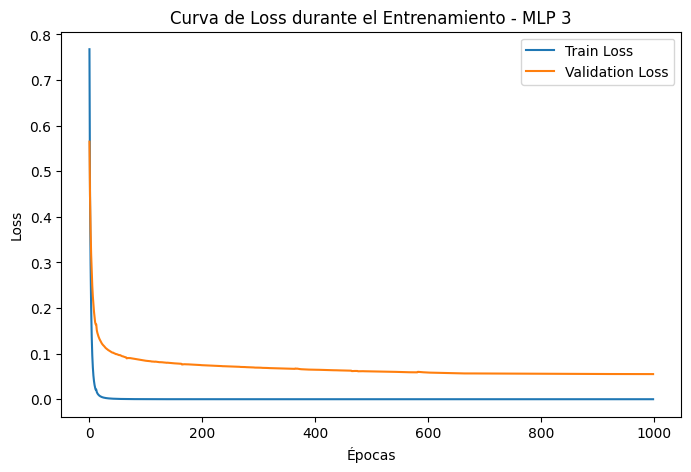

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)


if not isinstance(X_train, np.ndarray):
    X_train = X_train.values
if not isinstance(y_train, np.ndarray):
    y_train = y_train.values
if not isinstance(X_test, np.ndarray):
    X_test = X_test.values
if not isinstance(y_test, np.ndarray):
    y_test = y_test.values

# One‑hot para usar categorical_crossentropy (problema binario)
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat  = to_categorical(y_test,  num_classes=2)

# Definir dimensiones
input_dim     = X_train.shape[1]
hidden1_mlp3  = max(1, int(0.5 * input_dim))       # 50% de input_dim
hidden2_mlp3  = max(1, int(0.5 * hidden1_mlp3))    # 50% de hidden1

def create_mlp3_model(input_dim):
    model = Sequential()
    model.add(Dense(hidden1_mlp3, input_dim=input_dim, activation='relu'))
    model.add(Dense(hidden2_mlp3, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # 2 clases
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# --- K-Fold Cross Validation (10 folds) ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []
fold_no = 1

for train_index, val_index in kf.split(X_train):
    X_fold_train = X_train[train_index]
    X_fold_val   = X_train[val_index]
    y_fold_train = y_train_cat[train_index]
    y_fold_val   = y_train_cat[val_index]

    model = create_mlp3_model(input_dim)
    history = model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluación sobre el fold
    loss, keras_acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)

    # Predicciones para métricas adicionales
    y_val_prob = model.predict(X_fold_val, verbose=0)
    y_val_pred = np.argmax(y_val_prob, axis=1)
    y_val_true = np.argmax(y_fold_val, axis=1)

    # Cálculo de métricas sklearn
    acc   = accuracy_score(y_val_true, y_val_pred)
    auc   = roc_auc_score(y_val_true, y_val_prob[:,1])
    prec  = precision_score(y_val_true, y_val_pred)
    rec   = recall_score(y_val_true, y_val_pred)
    f1    = f1_score(y_val_true, y_val_pred)

    fold_results.append({
        "Fold": fold_no,
        "Epochs": len(history.history['loss']),
        "Val_Loss": loss,
        "Keras_Acc": keras_acc,
        "Accuracy": acc,
        "AUC": auc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

    print(f"Fold {fold_no} → Loss: {loss:.4f}, Acc: {acc:.4f}, "
          f"AUC: {auc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
    fold_no += 1

# Crear DataFrame y mostrar resultados por fold
results_df = pd.DataFrame(fold_results)
print("\nResultados por fold:")
print(results_df.to_string(index=False))

# -----------------------------
# Resumen de métricas: promedio y desviación estándar
stats   = results_df[[
    "Val_Loss", "Keras_Acc",
    "Accuracy", "AUC",
    "Precision", "Recall", "F1"
]]
summary = stats.agg(["mean", "std"]).transpose().reset_index()
summary.columns = ["Métrica", "Promedio", "Desviación estándar"]

print("\nMétricas promedio y SD (10 folds):")
print(summary.to_markdown(index=False, floatfmt=".4f"))

# -------------------------------------------------------------------
# Entrenamiento final con todo el set de entrenamiento
final_model = create_mlp3_model(input_dim)
history_final = final_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluación en el set de prueba
loss_test, acc_test = final_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nMLP 3 - Loss test: {loss_test:.4f}, Accuracy test: {acc_test:.4f}")

# Reporte de clasificación y matriz de confusión en test
y_pred_prob = final_model.predict(X_test, verbose=0)
y_pred      = np.argmax(y_pred_prob, axis=1)
y_true      = np.argmax(y_test_cat, axis=1)

print("\nReporte de Clasificación en test:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - MLP 3')
plt.show()

# Curva de Loss durante el entrenamiento
plt.figure(figsize=(8, 5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Loss durante el Entrenamiento - MLP 3')
plt.legend()
plt.show()


### **8.3. SVM**

#### **8.3.1. Linear-Kernel Support Vector Machine (SVM)**

##### **Architecture:**


---

This SVM variant employs a linear kernel, resulting in a decision boundary that takes the form of a single hyperplane in the original feature space. It is particularly well-suited to classification problems where the data are linearly separable or nearly so. The primary hyperparameter is C, which controls the trade-off between achieving a low training error and maintaining a large margin (i.e., regularization strength). Models with a higher C place greater emphasis on minimizing classification error, while smaller values favor a simpler decision boundary. Owing to its simplicity and computational efficiency, the linear-kernel SVM is commonly preferred in scenarios requiring interpretable models or rapid training.

Fold 1 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        76

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

--------------------------------------------------
Fold 2 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        77

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

--------------------------------------------------
Fold 3 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

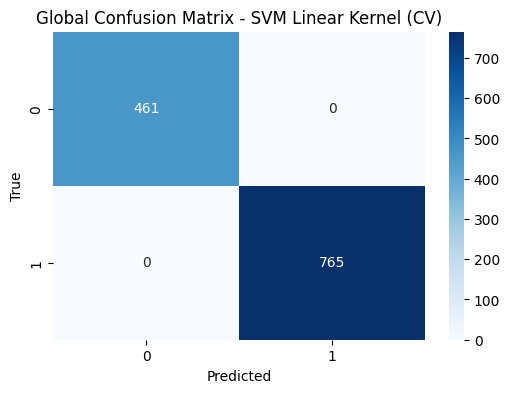

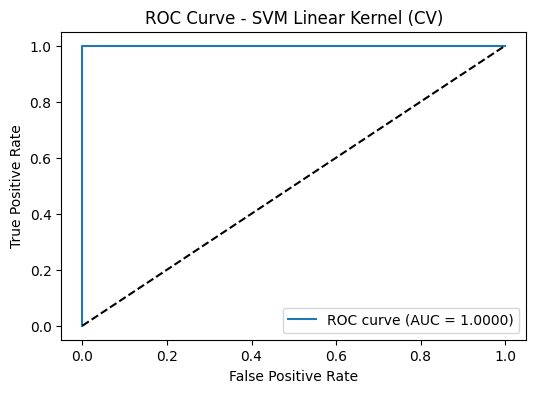

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assume X_train, y_train are defined
X = X_train.copy()
y = y_train.copy()

# Lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
auc_list = []
f1_list = []
fold_confusion_matrices = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_number = 1

for train_index, test_index in cv.split(X, y):
    # Split for this fold
    if isinstance(X, pd.DataFrame):
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
    else:
        X_tr, X_te = X[train_index], X[test_index]
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]
    else:
        y_tr, y_te = y[train_index], y[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_tr_imputed = imputer.fit_transform(X_tr)
    X_te_imputed = imputer.transform(X_te)

    # Train linear-kernel SVM
    model = SVC(kernel='linear', probability=True, random_state=42)
    model.fit(X_tr_imputed, y_tr)

    # Predictions
    y_pred = model.predict(X_te_imputed)
    y_proba = model.predict_proba(X_te_imputed)

    # Compute metrics
    acc = accuracy_score(y_te, y_pred)
    if len(np.unique(y)) == 2:
        auc  = roc_auc_score(y_te, y_proba[:, 1])
        prec = precision_score(y_te, y_pred, average='binary')
        rec  = recall_score(y_te, y_pred, average='binary')
        f1   = f1_score(y_te, y_pred, average='binary')
    else:
        auc  = roc_auc_score(y_te, y_proba, multi_class='ovr')
        prec = precision_score(y_te, y_pred, average='macro')
        rec  = recall_score(y_te, y_pred, average='macro')
        f1   = f1_score(y_te, y_pred, average='macro')

    # Save results
    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    auc_list.append(auc)
    f1_list.append(f1)
    fold_confusion_matrices.append(confusion_matrix(y_te, y_pred))

    # Display fold results
    print(f"Fold {fold_number} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_te, y_pred))
    print("-" * 50)
    fold_number += 1

# Compute mean and sample SD (ddof=1)
mean_accuracy  = np.mean(accuracy_list)
std_accuracy   = np.std(accuracy_list, ddof=1)
mean_precision = np.mean(precision_list)
std_precision  = np.std(precision_list, ddof=1)
mean_recall    = np.mean(recall_list)
std_recall     = np.std(recall_list, ddof=1)
mean_f1        = np.mean(f1_list)
std_f1         = np.std(f1_list, ddof=1)
mean_auc       = np.mean(auc_list)
std_auc        = np.std(auc_list, ddof=1)

print("Cross-validation summary (10 folds):")
print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")

# Global confusion matrix
global_cm = np.sum(fold_confusion_matrices, axis=0)
plt.figure(figsize=(6, 4))
sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Global Confusion Matrix - SVM Linear Kernel (CV)")
plt.show()

# Plot ROC curve for the last fold
fpr, tpr, _ = roc_curve(y_te, y_proba[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {mean_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear Kernel (CV)')
plt.legend()
plt.show()


#### **8.3.2. Polynomial-Kernel Support Vector Machine (SVM)**

This variant uses a polynomial kernel function of the form
K(x
,
x
′
)
=
(
γ
x
T
x
′
+
coef0
)
d
K(x,x
′
 )=(γx
T
 x
′
 +coef0)
d
 , enabling the algorithm to fit polynomial decision boundaries in the input space. The model is capable of capturing more complex, non-linear patterns than its linear counterpart by projecting the data into a higher-dimensional space implicitly. Key hyperparameters include:
degree: the degree
d
d of the polynomial function, which determines the model’s flexibility;
gamma: the kernel coefficient that influences the impact of individual training examples;
coef0: the independent term added to the kernel function, which can significantly affect decision boundaries at low degrees.
This kernel is particularly effective when the relationship between input features and output classes is believed to follow a polynomial structure.

Fold 1 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        76

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

--------------------------------------------------
Fold 2 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        77

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

--------------------------------------------------
Fold 3 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

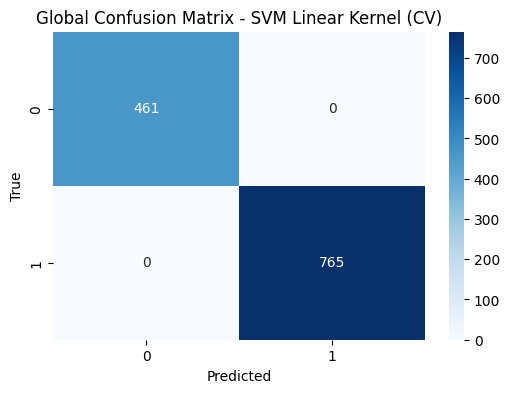

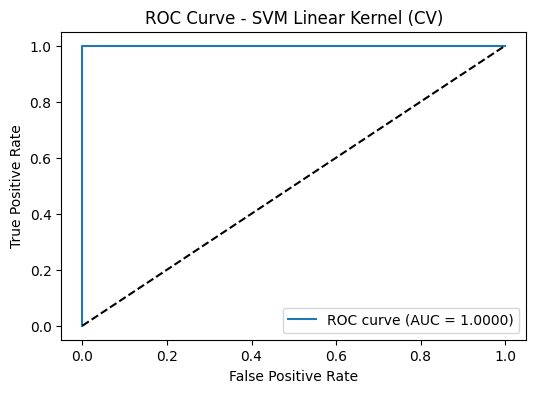

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X = X_train.copy()
y = y_train.copy()

# Initialize lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
auc_list = []
f1_list = []
fold_confusion_matrices = []

# Configure 10-fold StratifiedKFold to preserve class distribution
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_number = 1
for train_index, test_index in cv.split(X, y):
    if isinstance(X, pd.DataFrame):
        X_train_fold = X.iloc[train_index]
        X_test_fold = X.iloc[test_index]
    else:
        X_train_fold = X[train_index]
        X_test_fold = X[test_index]

    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_train_fold = y.iloc[train_index]
        y_test_fold = y.iloc[test_index]
    else:
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

    # Define linear SVM with probability=True for AUC
    model = SVC(kernel='linear', random_state=42, probability=True)
    model.fit(X_train_fold, y_train_fold)

    # Predict and get probabilities
    y_pred_fold = model.predict(X_test_fold)
    y_proba_fold = model.predict_proba(X_test_fold)

    # Compute metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    if len(np.unique(y)) == 2:
        auc = roc_auc_score(y_test_fold, y_proba_fold[:, 1])
        prec = precision_score(y_test_fold, y_pred_fold, average='binary')
        rec = recall_score(y_test_fold, y_pred_fold, average='binary')
        f1 = f1_score(y_test_fold, y_pred_fold, average='binary')
    else:
        auc = roc_auc_score(y_test_fold, y_proba_fold, multi_class='ovr')
        prec = precision_score(y_test_fold, y_pred_fold, average='macro')
        rec = recall_score(y_test_fold, y_pred_fold, average='macro')
        f1 = f1_score(y_test_fold, y_pred_fold, average='macro')

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    auc_list.append(auc)
    f1_list.append(f1)
    fold_confusion_matrices.append(confusion_matrix(y_test_fold, y_pred_fold))

    print(f"Fold {fold_number} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test_fold, y_pred_fold))
    print("-" * 50)
    fold_number += 1

# Compute means and standard deviations
mean_accuracy  = np.mean(accuracy_list)
mean_precision = np.mean(precision_list)
mean_recall    = np.mean(recall_list)
mean_f1        = np.mean(f1_list)
mean_auc       = np.mean(auc_list)

std_accuracy  = np.std(accuracy_list)
std_precision = np.std(precision_list)
std_recall    = np.std(recall_list)
std_f1        = np.std(f1_list)
std_auc       = np.std(auc_list)

print("Cross-validation summary (10 folds):")
print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")

tabla_resumen = pd.DataFrame({
    "Metric": ["Mean Accuracy", "Mean Precision", "Mean Recall", "Mean F1", "Mean AUC"],
    "Mean":   [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc],
    "±":      [std_accuracy, std_precision, std_recall, std_f1, std_auc]
})

print("\nSummary table of mean metrics (10-Fold CV):")
print(tabla_resumen)

# Global confusion matrix
global_cm = np.sum(fold_confusion_matrices, axis=0)
plt.figure(figsize=(6, 4))
sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Global Confusion Matrix - SVM Linear Kernel (CV)")
plt.show()

# Plot ROC curve for the last fold
fpr, tpr, _ = roc_curve(y_test_fold, y_proba_fold[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {mean_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear Kernel (CV)')
plt.legend()
plt.show()


#### **8.3.3. Radial Basis Function (RBF)-Kernel Support Vector Machine (SVM)**

##### **Architecture:**


---

Also known as the Gaussian kernel SVM, this model maps input data into an infinite-dimensional feature space via a radial basis function kernel defined as
K
(
x
,
x
′
)
=
exp
⁡
(
−
γ
∥
x
−
x
′
∥
2
)
K(x,x
′
 )=exp(−γ∥x−x
′
 ∥
2
 ). The resulting decision boundaries are highly flexible and capable of modeling complex, non-linear separations between classes. The principal hyperparameters are:
gamma: which determines the extent to which a single training example influences the shape of the decision boundary; smaller values produce smoother boundaries, while larger values yield more localized patterns;
C: which governs the regularization strength and controls the balance between margin size and classification accuracy.
The RBF kernel is generally the most powerful among the standard SVM kernels, especially in tasks where class boundaries are highly non-linear or not readily captured by simpler models.

Fold 1 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        76

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

--------------------------------------------------
Fold 2 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        77

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

--------------------------------------------------
Fold 3 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

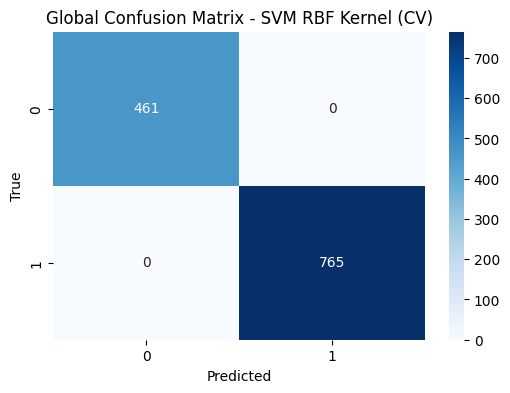

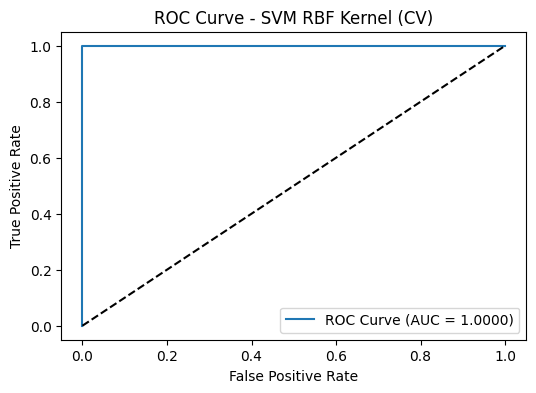

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
auc_list = []
f1_list = []
fold_confusion_matrices = []

# Configure stratified 10-fold cross-validation to preserve class distribution
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_number = 1
for train_index, test_index in cv.split(X, y):
    # If X or y are pandas objects, use .iloc for positional indexing
    if isinstance(X, (pd.DataFrame, pd.Series)):
        X_train_fold = X.iloc[train_index]
        X_test_fold  = X.iloc[test_index]
    else:
        X_train_fold = X[train_index]
        X_test_fold  = X[test_index]

    if isinstance(y, (pd.DataFrame, pd.Series)):
        y_train_fold = y.iloc[train_index]
        y_test_fold  = y.iloc[test_index]
    else:
        y_train_fold = y[train_index]
        y_test_fold  = y[test_index]

    # Define and train RBF-kernel SVM with probability=True (required for AUC)
    model = SVC(kernel='rbf', random_state=42, probability=True)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions and get probabilities
    y_pred_fold = model.predict(X_test_fold)
    y_proba_fold = model.predict_proba(X_test_fold)

    # Compute performance metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    if len(np.unique(y)) == 2:
        auc  = roc_auc_score(y_test_fold, y_proba_fold[:, 1])
        prec = precision_score(y_test_fold, y_pred_fold, average='binary')
        rec  = recall_score(y_test_fold, y_pred_fold, average='binary')
        f1   = f1_score(y_test_fold, y_pred_fold, average='binary')
    else:
        auc  = roc_auc_score(y_test_fold, y_proba_fold, multi_class='ovr')
        prec = precision_score(y_test_fold, y_pred_fold, average='macro')
        rec  = recall_score(y_test_fold, y_pred_fold, average='macro')
        f1   = f1_score(y_test_fold, y_pred_fold, average='macro')

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    auc_list.append(auc)
    f1_list.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    fold_confusion_matrices.append(cm)

    print(f"Fold {fold_number} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test_fold, y_pred_fold))
    print("-" * 50)
    fold_number += 1

# Compute mean and standard deviation for each metric
mean_accuracy  = np.mean(accuracy_list)
mean_precision = np.mean(precision_list)
mean_recall    = np.mean(recall_list)
mean_f1        = np.mean(f1_list)
mean_auc       = np.mean(auc_list)

std_accuracy  = np.std(accuracy_list)
std_precision = np.std(precision_list)
std_recall    = np.std(recall_list)
std_f1        = np.std(f1_list)
std_auc       = np.std(auc_list)

print("Cross-validation summary (10 folds):")
print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")

# Create a summary table of mean metrics and their standard deviations
tabla_resumen = pd.DataFrame({
    "Metric": ["Mean Accuracy", "Mean Precision", "Mean Recall", "Mean F1", "Mean AUC"],
    "Mean":   [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc],
    "±":      [std_accuracy, std_precision, std_recall, std_f1, std_auc]
})

print("\nSummary table of mean metrics (10-Fold CV):")
print(tabla_resumen)

# Sum confusion matrices across folds to get the global confusion matrix
global_cm = np.sum(fold_confusion_matrices, axis=0)

# Plot global confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Global Confusion Matrix - SVM RBF Kernel (CV)")
plt.show()

# Plot ROC curve for the last fold
fpr, tpr, _ = roc_curve(y_test_fold, y_proba_fold[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM RBF Kernel (CV)')
plt.legend()
plt.show()


# **8.4. KNN**

#### **8.4.1. KNN (3 Neighbors)**

##### **Architecture:**

---
When
k = 3
k=3, the model considers only the three nearest neighbors, using the standard Euclidean distance metric to determine proximity. Classification is performed via majority voting among these three neighbors. This configuration exhibits low bias, enabling it to capture intricate decision boundaries and fit complex patterns in the data. However, this expressiveness comes at the cost of higher variance, making the model particularly sensitive to noise and outliers.

Per-fold metrics:
  Fold  Accuracy  Precision   Recall  F1 Score      AUC
    1  0.721591   0.785047 0.763636  0.774194 0.767837
    2  0.750000   0.784483 0.827273  0.805310 0.753099
    3  0.748571   0.794643 0.809091  0.801802 0.740070
    4  0.685714   0.741071 0.761468  0.751131 0.740756
    5  0.697143   0.754545 0.761468  0.757991 0.694885
    6  0.708571   0.784314 0.733945  0.758294 0.761815
    7  0.754286   0.794643 0.816514  0.805430 0.762510
    8  0.777143   0.836538 0.798165  0.816901 0.812135
    9  0.725714   0.808081 0.733945  0.769231 0.792188
   10  0.731429   0.803922 0.752294  0.777251 0.798791

Summary (mean ± std):
   Metric   Mean  StdDev
 Accuracy 0.7300  0.0282
Precision 0.7887  0.0268
   Recall 0.7758  0.0342
 F1 Score 0.7818  0.0237
      AUC 0.7624  0.0339


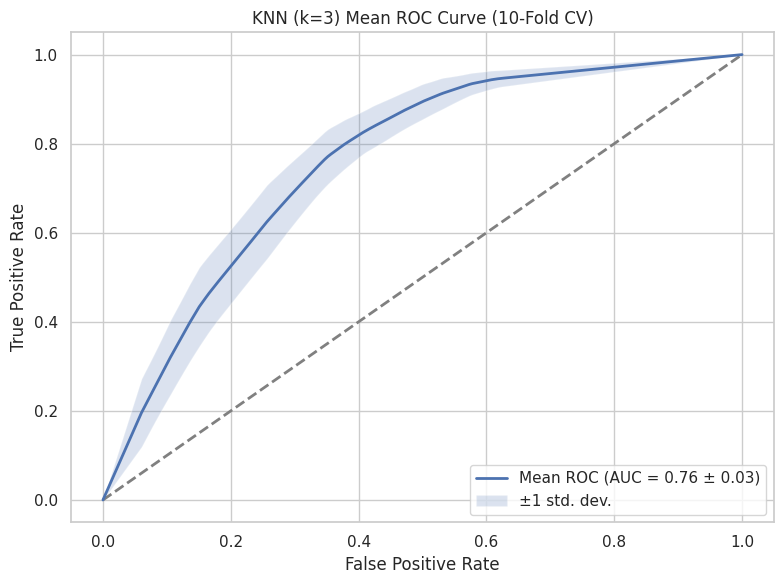


Confusion Matrix:
 [[431 228]
 [245 848]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65       659
           1       0.79      0.78      0.78      1093

    accuracy                           0.73      1752
   macro avg       0.71      0.71      0.71      1752
weighted avg       0.73      0.73      0.73      1752



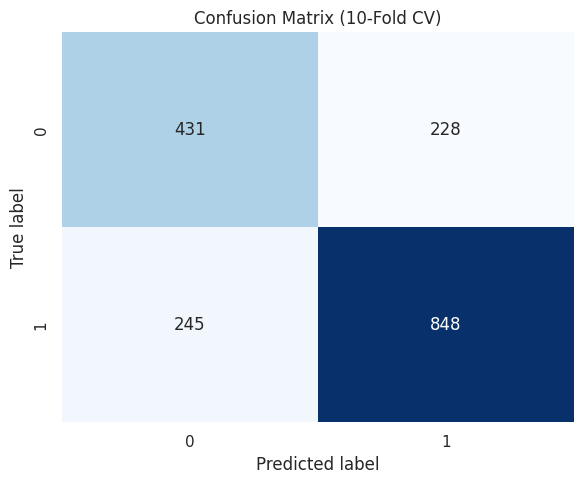

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report
)

sns.set(style="whitegrid")

# --- Data preparation ---
X_raw = features  # your DataFrame of predictors
y = df['InjDefn_binary'].values

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X_raw)

# --- Cross-validation setup ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)

# Containers
accs, precs, recs, f1s, aucs = [], [], [], [], []
tprs = []
mean_fpr = np.linspace(0, 1, 200)

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    knn.fit(X_tr, y_tr)
    y_pred = knn.predict(X_te)
    y_proba = knn.predict_proba(X_te)[:, 1]

    # metrics
    accs.append(accuracy_score(y_te, y_pred))
    precs.append(precision_score(y_te, y_pred))
    recs.append(recall_score(y_te, y_pred))
    f1s.append(f1_score(y_te, y_pred))
    fold_auc = roc_auc_score(y_te, y_proba)
    aucs.append(fold_auc)

    # collect for mean ROC
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# --- Print per-fold and summary metrics ---
metrics_df = pd.DataFrame({
    'Fold':      np.arange(1, 11),
    'Accuracy':  accs,
    'Precision': precs,
    'Recall':    recs,
    'F1 Score':  f1s,
    'AUC':       aucs
})
print("Per-fold metrics:\n", metrics_df.to_string(index=False))

summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Mean':   [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(f1s), np.mean(aucs)],
    'StdDev': [np.std(accs, ddof=1), np.std(precs, ddof=1),
               np.std(recs, ddof=1), np.std(f1s, ddof=1), np.std(aucs, ddof=1)]
})
print("\nSummary (mean ± std):")
print(summary.to_string(index=False, float_format='%.4f'))

# --- Final ROC — plotted at the very end ---
mean_tpr = np.mean(tprs, axis=0)
std_tpr  = np.std(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc  = np.std(aucs, ddof=1)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.plot(mean_fpr, mean_tpr,
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2)
upper = np.minimum(mean_tpr + std_tpr, 1)
lower = mean_tpr - std_tpr
plt.fill_between(mean_fpr, lower, upper, alpha=0.2, label='±1 std. dev.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN (k=3) Mean ROC Curve (10-Fold CV)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# --- Confusion matrix & classification report on full CV predictions ---
y_pred_full = cross_val_predict(knn, X, y, cv=cv, method='predict')
cm = confusion_matrix(y, y_pred_full)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y, y_pred_full))

# Optional: plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (10-Fold CV)')
plt.tight_layout()
plt.show()


 #### **8.4.2. KNN (5 Neighbors)**

##### **Architecture**



---


In contrast, the
k = 5 configuration represents a more balanced approach. By averaging over a slightly larger neighborhood, it achieves a better bias–variance trade-off. The increased neighbor count makes the model more robust to local fluctuations and noise while still maintaining sufficient flexibility to model moderately complex relationships.

Results for each fold (KNN with 5 neighbors):
 Fold  Accuracy  Precision  Recall    AUC     F1
    1    0.7398     0.8000  0.7792 0.7883 0.7895
    2    0.6423     0.7200  0.7013 0.7109 0.7105
    3    0.6504     0.7215  0.7308 0.6503 0.7261
    4    0.7480     0.8052  0.7949 0.8067 0.8000
    5    0.6504     0.7273  0.7179 0.6444 0.7226
    6    0.6667     0.7342  0.7436 0.7174 0.7389
    7    0.6967     0.7381  0.8052 0.6838 0.7702
    8    0.6230     0.7013  0.7013 0.6266 0.7013
    9    0.6148     0.6875  0.7143 0.6556 0.7006
   10    0.6311     0.6860  0.7662 0.6102 0.7239

Average metrics table (± sample SD):
   Metric   Mean     SD
 Accuracy 0.6663 0.0470
Precision 0.7321 0.0413
   Recall 0.7455 0.0386
      AUC 0.6894 0.0664
       F1 0.7384 0.0359

Classification Report (CV):
              precision    recall  f1-score   support

           0     0.5492    0.5310    0.5399       452
           1     0.7313    0.7455    0.7383       774

    accuracy                         0.6

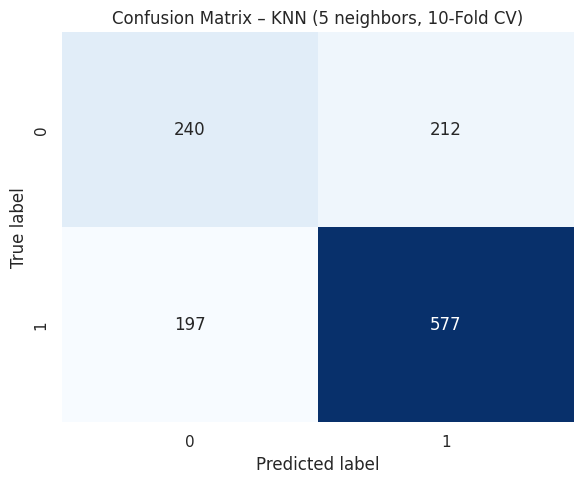

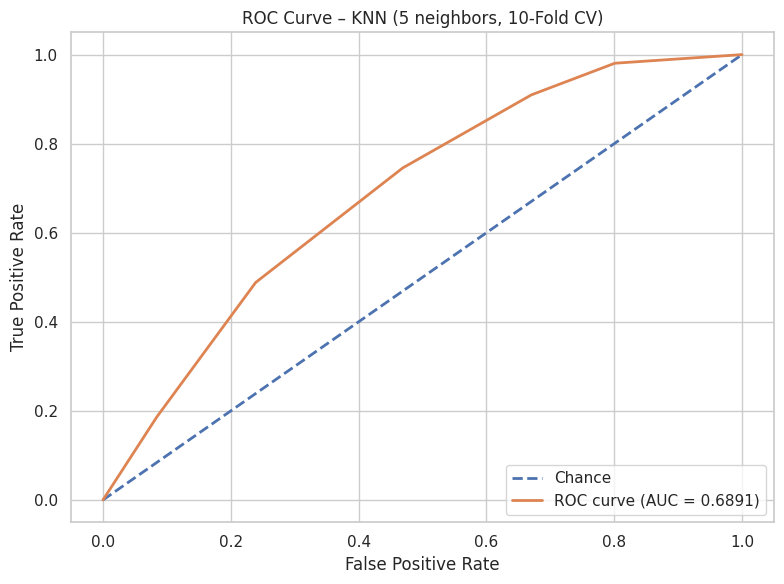

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    classification_report, confusion_matrix
)

sns.set(style="whitegrid")

# --- Data preparation ---
target = df['InjDefn_binary']
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed  = imputer.transform(X_test)

# --- Cross-validation setup ---
knn_5 = KNeighborsClassifier(n_neighbors=5)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    'accuracy':  'accuracy',
    'precision': 'precision',
    'recall':    'recall',
    'roc_auc':   'roc_auc',
    'f1':        'f1'
}

# --- Run cross-validation to collect metrics ---
cv_results = cross_validate(
    knn_5, X_train_imputed, y_train,
    cv=cv, scoring=scoring, return_train_score=False
)

# --- Per-fold results ---
folds_df = pd.DataFrame({
    "Fold":      np.arange(1, 11),
    "Accuracy":  cv_results['test_accuracy'],
    "Precision": cv_results['test_precision'],
    "Recall":    cv_results['test_recall'],
    "AUC":       cv_results['test_roc_auc'],
    "F1":        cv_results['test_f1']
})
print("Results for each fold (KNN with 5 neighbors):")
print(folds_df.to_string(index=False, float_format='%.4f'))

# --- Mean ± sample SD ---
means = { m: np.mean(cv_results[f'test_{m}']) for m in scoring }
stds  = { m: np.std(cv_results[f'test_{m}'], ddof=1) for m in scoring }

avg_metrics_df = pd.DataFrame({
    "Metric":  ["Accuracy", "Precision", "Recall", "AUC", "F1"],
    "Mean":    [means['accuracy'], means['precision'], means['recall'], means['roc_auc'], means['f1']],
    "SD":      [stds['accuracy'],  stds['precision'],  stds['recall'],  stds['roc_auc'],  stds['f1']]
})
print("\nAverage metrics table (± sample SD):")
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(avg_metrics_df.to_string(index=False))

# --- CV predictions for classification report & confusion matrix ---
y_pred_cv  = cross_val_predict(knn_5, X_train_imputed, y_train, cv=cv, method='predict')
y_proba_cv = cross_val_predict(knn_5, X_train_imputed, y_train, cv=cv, method='predict_proba')[:, 1]

print("\nClassification Report (CV):")
print(classification_report(y_train, y_pred_cv, digits=4))

cm = confusion_matrix(y_train, y_pred_cv)
print("Confusion Matrix (CV):\n", cm)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix – KNN (5 neighbors, 10-Fold CV)')
plt.tight_layout()
plt.show()

# --- ROC curve at the end ---
fpr, tpr, _ = roc_curve(y_train, y_proba_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Chance')
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – KNN (5 neighbors, 10-Fold CV)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### **8.4.3. KNN (7 Neighbors)**

##### **Architecture:**


---
With
k = 7, the algorithm leans further toward stability and generalization. Using a larger set of nearest neighbors tends to smooth the decision boundary, thereby increasing bias while simultaneously reducing variance. This configuration is more resistant to overfitting and produces more consistent predictions across different datasets. However, its higher bias may result in underfitting, particularly in scenarios where class boundaries are highly non-linear or intricate.

Per-fold results (KNN, k=7):
 Fold  Accuracy  Precision  Recall    AUC     F1
    1    0.7236     0.7792  0.7792 0.7722 0.7792
    2    0.6260     0.6914  0.7273 0.6659 0.7089
    3    0.6423     0.7073  0.7436 0.6333 0.7250
    4    0.7317     0.7848  0.7949 0.7785 0.7898
    5    0.6504     0.7108  0.7564 0.6380 0.7329
    6    0.6667     0.7176  0.7821 0.6980 0.7485
    7    0.6475     0.7125  0.7403 0.6610 0.7261
    8    0.6311     0.6905  0.7532 0.6345 0.7205
    9    0.6475     0.7024  0.7662 0.6623 0.7329
   10    0.6311     0.6818  0.7792 0.6014 0.7273

Average metrics (± sample SD):
   Metric   Mean     SD
 Accuracy 0.6598 0.0377
Precision 0.7178 0.0356
   Recall 0.7622 0.0217
      AUC 0.6745 0.0589
       F1 0.7391 0.0261

Classification Report (CV on training set):
              precision    recall  f1-score   support

           0     0.5434    0.4845    0.5123       452
           1     0.7169    0.7623    0.7389       774

    accuracy                         0.6599    

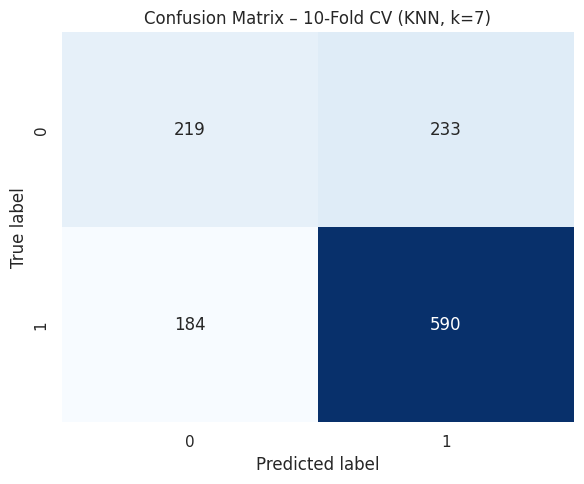

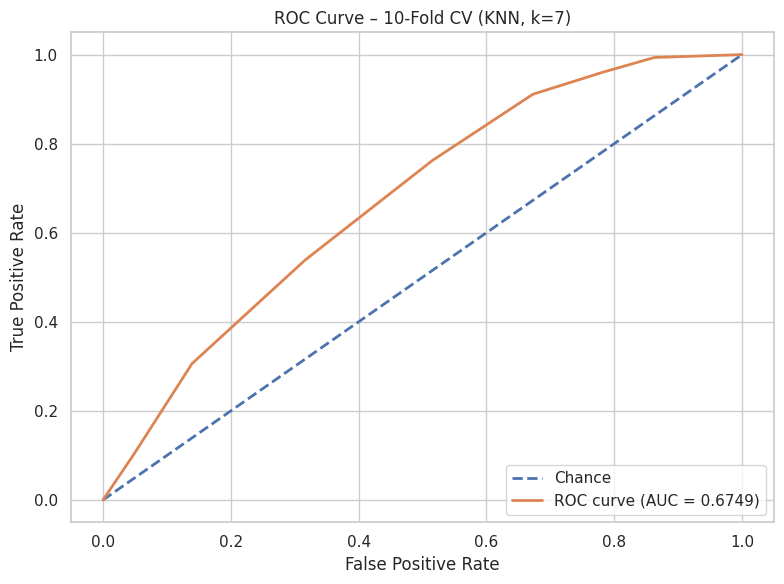

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    classification_report, confusion_matrix
)

sns.set(style="whitegrid")

# --- Data preparation ---
# Assume `df` contains your data and `features` is the DataFrame of predictors
y = df['InjDefn_binary'].values
X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.3, random_state=42
)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed  = imputer.transform(X_test)

# --- Cross-validation setup ---
knn = KNeighborsClassifier(n_neighbors=7)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    'accuracy':  'accuracy',
    'precision': 'precision',
    'recall':    'recall',
    'roc_auc':   'roc_auc',
    'f1':        'f1'
}

# --- Run cross-validation for metrics ---
cv_results = cross_validate(
    knn,
    X_train_imputed,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# --- Per-fold results ---
folds_df = pd.DataFrame({
    "Fold":      np.arange(1, len(cv_results['test_accuracy']) + 1),
    "Accuracy":  cv_results['test_accuracy'],
    "Precision": cv_results['test_precision'],
    "Recall":    cv_results['test_recall'],
    "AUC":       cv_results['test_roc_auc'],
    "F1":        cv_results['test_f1']
})
print("Per-fold results (KNN, k=7):")
print(folds_df.to_string(index=False, float_format='%.4f'))

# --- Mean ± sample SD ---
metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
means = {m: np.mean(cv_results[f'test_{m}']) for m in metrics}
stds  = {m: np.std(cv_results[f'test_{m}'], ddof=1) for m in metrics}

avg_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "AUC", "F1"],
    "Mean":   [means['accuracy'], means['precision'], means['recall'],
               means['roc_auc'], means['f1']],
    "SD":     [stds['accuracy'],  stds['precision'],  stds['recall'],
               stds['roc_auc'],  stds['f1']]
})
print("\nAverage metrics (± sample SD):")
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(avg_df.to_string(index=False))

# --- Classification report & confusion matrix via CV-predict ---
y_pred_cv  = cross_val_predict(knn, X_train_imputed, y_train, cv=cv, method='predict')
y_proba_cv = cross_val_predict(knn, X_train_imputed, y_train, cv=cv, method='predict_proba')[:, 1]

print("\nClassification Report (CV on training set):")
print(classification_report(y_train, y_pred_cv, digits=4))

cm = confusion_matrix(y_train, y_pred_cv)
print("Confusion Matrix (CV on training set):")
print(cm)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix – 10-Fold CV (KNN, k=7)')
plt.tight_layout()
plt.show()

# --- ROC curve at the end ---
fpr, tpr, _ = roc_curve(y_train, y_proba_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Chance')
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – 10-Fold CV (KNN, k=7)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# **8.4.5. Naive Bayes**

##### **Architecture**


---

The Gaussian Naive Bayes classifier is a generative probabilistic model grounded in Bayes’ theorem, operating under the simplifying assumption that all features are conditionally independent given the class label. This "naive" independence assumption significantly reduces computational complexity and facilitates efficient parameter estimation. During the training phase, the model computes the prior probability of each class based on its relative frequency in the dataset. Simultaneously, it estimates the parameters (mean and variance) of a Gaussian distribution for each feature, conditional on each class.
During inference, the model evaluates the likelihood of a given test instance under each class by assuming that the features follow class-specific univariate Gaussian distributions. These likelihoods are then multiplied by the corresponding class priors to produce unnormalized posterior probabilities. The predicted label corresponds to the class with the highest posterior probability.
Despite its algorithmic simplicity and the strong independence assumption, the Gaussian Naive Bayes classifier often yields robust and computationally efficient performance, particularly in scenarios where feature distributions are approximately normal and exhibit low interdependence.

Results for each fold (Naive Bayes):
   Fold  Accuracy  Precision  Recall       AUC        F1
0     1   1.00000   1.000000     1.0  1.000000  1.000000
1     2   1.00000   1.000000     1.0  1.000000  1.000000
2     3   1.00000   1.000000     1.0  1.000000  1.000000
3     4   1.00000   1.000000     1.0  1.000000  1.000000
4     5   1.00000   1.000000     1.0  1.000000  1.000000
5     6   0.99187   0.987342     1.0  0.988889  0.993631
6     7   1.00000   1.000000     1.0  1.000000  1.000000
7     8   1.00000   1.000000     1.0  1.000000  1.000000
8     9   1.00000   1.000000     1.0  1.000000  1.000000
9    10   1.00000   1.000000     1.0  1.000000  1.000000

Average metrics (± sample SD):
Mean Accuracy:  0.9992 ± 0.0026
Mean Precision: 0.9987 ± 0.0040
Mean Recall:    1.0000 ± 0.0000
Mean AUC:       0.9989 ± 0.0035
Mean F1 Score:  0.9994 ± 0.0020

Average metrics table (± sample SD):
      Metric   Mean     SD
0   Accuracy 0.9992 0.0026
1  Precision 0.9987 0.0040
2     Recall 1.0000 0.000

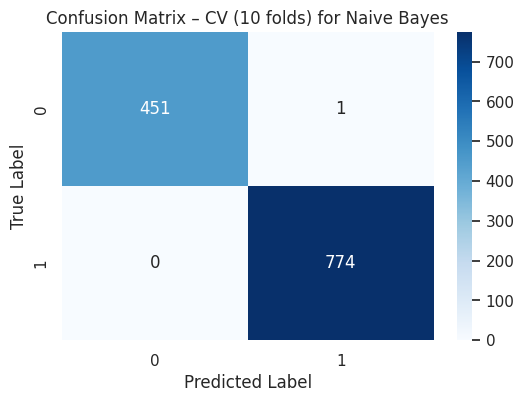

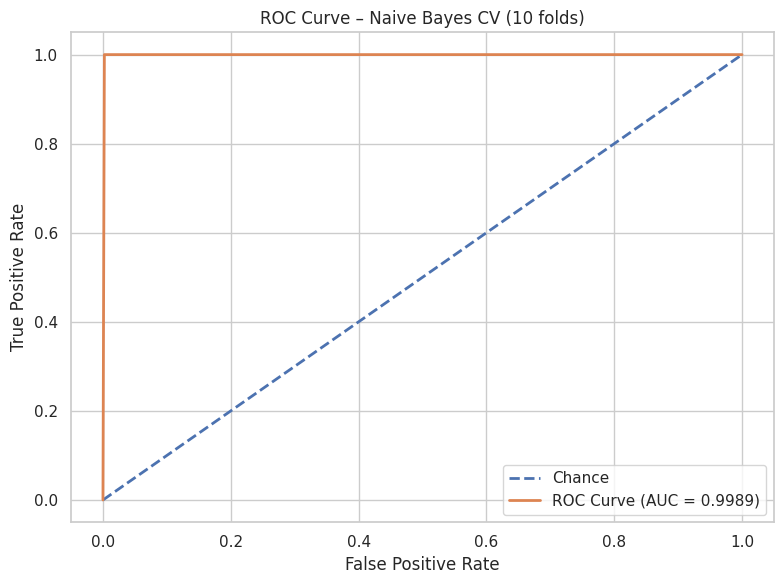

In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

target = df['InjDefn_binary']

# Split dataset into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

# Impute missing values (NaN) in X_train and X_test
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed  = imputer.transform(X_test)

# Define the Naive Bayes model (GaussianNB)
nb_model = GaussianNB()

# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Metrics to evaluate
scoring = {
    'accuracy':  'accuracy',
    'precision': 'precision',
    'recall':    'recall',
    'roc_auc':   'roc_auc',
    'f1':        'f1'
}

# Run cross-validation and capture results
cv_results = cross_validate(
    nb_model,
    X_train_imputed,
    y_train,
    cv=skf,
    scoring=scoring
)

# Results for each fold
folds_df = pd.DataFrame({
    "Fold":      np.arange(1, len(cv_results['test_accuracy']) + 1),
    "Accuracy":  cv_results['test_accuracy'],
    "Precision": cv_results['test_precision'],
    "Recall":    cv_results['test_recall'],
    "AUC":       cv_results['test_roc_auc'],
    "F1":        cv_results['test_f1']
})
print("Results for each fold (Naive Bayes):")
print(folds_df)

# Compute means
mean_accuracy  = np.mean(cv_results['test_accuracy'])
mean_precision = np.mean(cv_results['test_precision'])
mean_recall    = np.mean(cv_results['test_recall'])
mean_auc       = np.mean(cv_results['test_roc_auc'])
mean_f1        = np.mean(cv_results['test_f1'])

# Compute sample standard deviations (ddof=1)
std_accuracy  = np.std(cv_results['test_accuracy'],  ddof=1)
std_precision = np.std(cv_results['test_precision'], ddof=1)
std_recall    = np.std(cv_results['test_recall'],    ddof=1)
std_auc       = np.std(cv_results['test_roc_auc'],   ddof=1)
std_f1        = np.std(cv_results['test_f1'],        ddof=1)

# Print mean ± SD for each metric
print("\nAverage metrics (± sample SD):")
print(f"Mean Accuracy:  {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean Recall:    {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean AUC:       {mean_auc:.4f} ± {std_auc:.4f}")
print(f"Mean F1 Score:  {mean_f1:.4f} ± {std_f1:.4f}")

# Summary table of average metrics with SD
avg_metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "AUC", "F1"],
    "Mean":   [mean_accuracy, mean_precision, mean_recall, mean_auc, mean_f1],
    "SD":     [std_accuracy, std_precision, std_recall, std_auc, std_f1]
})
print("\nAverage metrics table (± sample SD):")
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(avg_metrics_df)

# Classification report & confusion matrix using cross_val_predict
y_pred_cv = cross_val_predict(nb_model, X_train_imputed, y_train, cv=skf)
print("\nClassification Report (CV):")
print(classification_report(y_train, y_pred_cv))

cm = confusion_matrix(y_train, y_pred_cv)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – CV (10 folds) for Naive Bayes")
plt.show()

# Add ROC curve at the end
y_proba_cv = cross_val_predict(nb_model, X_train_imputed, y_train, cv=skf, method='predict_proba')[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_proba_cv)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Chance')
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc_value:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Naive Bayes CV (10 folds)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## **9. Conclusions & Future Work**

With respect to the five classifiers—Random Forest, Multilayer Perceptron (MLP), Support Vector Machine (SVM), k-Nearest Neighbors (KNN), and Gaussian Naive Bayes. The Random Forest and MLP classifiers produced the top overall prediction quality, with consistent mean accuracy and AUC in the upper 0.90s. Random Forest performed supremely with respect to feature interactions and produced the most consistent recall over minority classes, whereas the MLP’s non-linear feature learning produced the highest F1-score levels at the price of longer training and increased sensitivity to hyperparameters. The RBF-kernel SVM furnished a good compromise—strong AUC and precision—but at the price of precise tuning of C and gamma. KNN (with k=3,5,7) operated reasonably well in regions of low noise but was subject to increased variance and suffered in larger dimensional subspaces, exemplifying the curse of dimensionality. Lastly, Gaussian Naive Bayes trained the quickest and gave a reliable baseline, but its independence assumption came at the cost of lower AUC and recall relative to the others. Confusion matrices and ROC-curves reinforce the above: ensembles and neural methods pushed the decision boundaries strongest, SVM created a good “black-box” compromise, whereas KNN and NB were reserved for quick prototyping or where the tradeoff between interpretability and speed trumped the incremental gain in accuracy.

In order to leverage these findings, a few avenues should be explored. Firstly, ensemble stacking of Random Forest, MLP, and SVM predictions could play to their complementary strengths to improve robustness and reduce single deficiencies. Secondly, more deep hyperparameter optimization of the MLP (such as architecture depth and learning schedules) and SVM (kernel selection and regularization paths) via Bayesian search is bound to extract further performance. Thirdly, integrating feature selection (like recursive elimination or mutual information) or dimensionality reduction beyond PCA (like autoencoders) can recover competitiveness by filtering out noise. Fourth, investigating probabilistic generalizations of Naive Bayes (such as semi-naive classifiers or Bayesian networks) may reclaim part of its speed benefit at the cost of weaker independence approximations. Last but not least, acquiring more heterogeneous gait and sensor data (kin, time-series accelerometry) and supplementing training with data-driven synthetic samples will enhance generalization, especially to under-represented injury classes. Such measures will hone our framework for injury prediction into a more accurate, more understandable, and more efficiently computing system of deployment in the field.